In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wooldridge as woo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chi2
from scipy.linalg import solve, inv, cholesky
import warnings
warnings.filterwarnings('ignore')

# --- Setup for R integration ---
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:

# Load the 'jtrain' dataset from the Wooldridge collection
jtrain = woo.data('jtrain2')

# Display a description of the variables in the dataset
print(woo.data('jtrain2', description=True))

name of dataset: jtrain2
no of variables: 19
no of observations: 445

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| train    | =1 if assigned to job training  |
| age      | age in 1977                     |
| educ     | years of education              |
| black    | =1 if black                     |
| hisp     | =1 if Hispanic                  |
| married  | =1 if married                   |
| nodegree | =1 if no high school degree     |
| mosinex  | # mnths prior to 1/78 in expmnt |
| re74     | real earns., 1974, $1000s       |
| re75     | real earns., 1975, $1000s       |
| re78     | real earns., 1978, $1000s       |
| unem74   | =1 if unem. all of 1974         |
| unem75   | =1 if unem. all of 1975         |
| unem78   | =1 if unem. all of 1978         |
| lre74    | log(re74); zero if re74 == 0    |
| lre75    | log(re75); zero if re75 == 0    |
| lre78    | log(re78); zero if re78 

In [3]:
# --- Impact Effect Estimation ---

# Define the regression model
# We are estimating the effect of 'train' (the intervention) on 'unem78' (the outcome).
# We include other variables as controls to account for potential confounding factors.
# The formula is: unem78 ~ train + age + educ + black + hisp + re74 + re75
# The coefficient on the 'train' variable will be our estimate of the impact effect.

model = smf.ols('unem78 ~ train + age + educ + black + hisp + re74 + re75', data=jtrain)

# Fit the model
results = model.fit()

# Print the summary of the regression results
print("\n--- OLS Regression Results ---")
print(results.summary())

# --- Interpretation of the Impact Effect ---

# The coefficient for the 'train' variable in the regression output represents the estimated impact
# of the job training program on the probability of being unemployed in 1978, holding other factors constant.

# A negative coefficient suggests that participation in the training program is associated with a
# lower probability of unemployment. The p-value associated with this coefficient will indicate
# whether this effect is statistically significant.


--- OLS Regression Results ---
                            OLS Regression Results                            
Dep. Variable:                 unem78   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.120
Date:                qui, 03 jul 2025   Prob (F-statistic):            0.00318
Time:                        15:30:17   Log-Likelihood:                -276.58
No. Observations:                 445   AIC:                             569.2
Df Residuals:                     437   BIC:                             601.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.225

In [4]:
# Pulse Intervention form

# Load the housing investment dataset
hseinv = woo.data('hseinv')

# --- Define the Pulse Intervention Variable ---
# The intervention is a one-time tax credit in the year 1985.
# We create a dummy variable that is 1 for 1985 and 0 otherwise.
hseinv['tax_credit'] = (hseinv['year'] == 1985).astype(int)

print("Dataset with Pulse Intervention Variable (tax_credit):")
# Displaying years around the intervention
print(hseinv[hseinv['year'].between(1983, 1987)])
print("\n")

Dataset with Pulse Intervention Variable (tax_credit):
    year       inv       pop   price       linv       lpop    lprice   t  \
36  1983  122819.0  234799.0  0.9836  11.718467  12.366485 -0.016536  37   
37  1984  145166.0  237001.0  0.9836  11.885633  12.375819 -0.016536  38   
38  1985  146311.0  239279.0  0.9760  11.893490  12.385386 -0.024293  39   
39  1986  168406.0  241625.0  0.9760  12.034133  12.395143 -0.024293  40   
40  1987  167459.0  243934.0  0.9892  12.028494  12.404653 -0.010859  41   

       invpc    linvpc  lprice_1  linvpc_1    gprice    ginvpc  tax_credit  
36  0.523081 -0.648018  0.000000 -1.010144 -0.016536  0.362126           0  
37  0.612512 -0.490186 -0.016536 -0.648018  0.000000  0.157832           0  
38  0.611466 -0.491896 -0.016536 -0.490186 -0.007757 -0.001709           1  
39  0.696973 -0.361009 -0.024293 -0.491896  0.000000  0.130887           0  
40  0.686493 -0.376159 -0.024293 -0.361009  0.013434 -0.015150           0  




In [5]:
# --- Set up the Estimation Model ---
# We can estimate the effect of this pulse using a time series regression.
# We model per capita investment (invpc) as a function of its own lag,
# the housing price index (price), and our pulse variable (tax_credit).
model_pulse = smf.ols('invpc ~ price + tax_credit', data=hseinv)

# To run the model, you would use:
results_pulse = model_pulse.fit()
print(results_pulse.summary())

print("Model for Pulse Function Intervention:")
print(model_pulse.formula)

                            OLS Regression Results                            
Dep. Variable:                  invpc   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     5.433
Date:                qui, 03 jul 2025   Prob (F-statistic):            0.00829
Time:                        15:30:17   Log-Likelihood:                 45.970
No. Observations:                  42   AIC:                            -85.94
Df Residuals:                      39   BIC:                            -80.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1188      0.205     -0.579      0.5

In [6]:
#Gradually Changing Intervention form

# Load the barium industry dataset
barium = woo.data('barium')

# --- Define the Gradually Changing Intervention Variable ---
# This part of the code was correct.
conditions = [
    (barium['t'].between(51, 62)),  # Mar 1982 - Feb 1983
    (barium['t'].between(63, 74)),  # Mar 1983 - Feb 1984
    (barium['t'] >= 75)             # Mar 1984 onwards
]
values = [0.33, 0.66, 1.0]
barium['tariff_phasein'] = 0.0
for cond, val in zip(conditions, values):
    barium.loc[cond, 'tariff_phasein'] = val

In [7]:
# --- BUILD THE MODEL  ---
# Based on the printed output, we now use the correct, all-lowercase names.
monthly_dummies = ' + '.join(['feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

formula = f'chnimp ~ tariff_phasein + lchempi + lrtwex + {monthly_dummies}'

model_gradual = smf.ols(formula, data=barium)


# To run the model:
results_gradual = model_gradual.fit()
print(results_gradual.summary())

print("\nModel for Gradually Changing Function Intervention:")
print(model_gradual.formula)

                            OLS Regression Results                            
Dep. Variable:                 chnimp   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     4.023
Date:                qui, 03 jul 2025   Prob (F-statistic):           1.23e-05
Time:                        15:30:17   Log-Likelihood:                -926.67
No. Observations:                 131   AIC:                             1883.
Df Residuals:                     116   BIC:                             1926.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1557.7768   3198.384     -0.

In [8]:
# Prolonged Impulse Intervention form

# Load the 'crime4' panel dataset
crime4 = woo.data('crime4')

# --- Define the Prolonged Impulse Intervention Variable ---
# We hypothesize a new, stricter sentencing law was enacted in 1984
# and remained in effect for the rest of the dataset's period.
# This creates a dummy variable that is 0 for 1981-83 and 1 for 1984-87.
crime4['law_active'] = (crime4['year'] >= 84).astype(int)


# --- Display the data to verify the new variable ---
print("Dataset with Prolonged Impulse Variable ('law_active'):")
# Display data for the first county (county==1) to show the intervention starting
# We use .head(7) to show all years for that county.
print(crime4[['year', 'county', 'crmrte', 'law_active']].loc[crime4['county'] == 1].head(7))
print("\n")



Dataset with Prolonged Impulse Variable ('law_active'):
   year  county    crmrte  law_active
0    81       1  0.039885           0
1    82       1  0.038345           0
2    83       1  0.030305           0
3    84       1  0.034726           1
4    85       1  0.036573           1
5    86       1  0.034752           1
6    87       1  0.035604           1




In [9]:
# --- Set up the Estimation Model ---
# A fixed-effects model is appropriate to control for time-invariant
# county characteristics and common time trends across all counties.
# We model the crime rate as a function of the new law and other control variables
# from the dataset, such as probability of conviction and police per capita.
formula = 'crmrte ~ law_active + prbconv + prbpris + polpc + C(county) + C(year)'
model_prolonged = smf.ols(formula, data=crime4)

# To run the model and see the results, you would uncomment these lines:
results_prolonged = model_prolonged.fit()
print(results_prolonged.summary())

print("Model for Prolonged Impulse Function Intervention:")
print(f"'{model_prolonged.formula}'")

                            OLS Regression Results                            
Dep. Variable:                 crmrte   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     53.88
Date:                qui, 03 jul 2025   Prob (F-statistic):          1.55e-221
Time:                        15:30:17   Log-Likelihood:                 2387.0
No. Observations:                 630   AIC:                            -4576.
Df Residuals:                     531   BIC:                            -4136.
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0327      0.003  

--- Data Loaded and Indexed Correctly ---
         realgdp  realcons
1959Q1  2710.349    1707.4
1959Q2  2778.801    1733.7
1959Q3  2775.488    1751.8
1959Q4  2785.204    1753.7
1960Q1  2847.699    1770.5




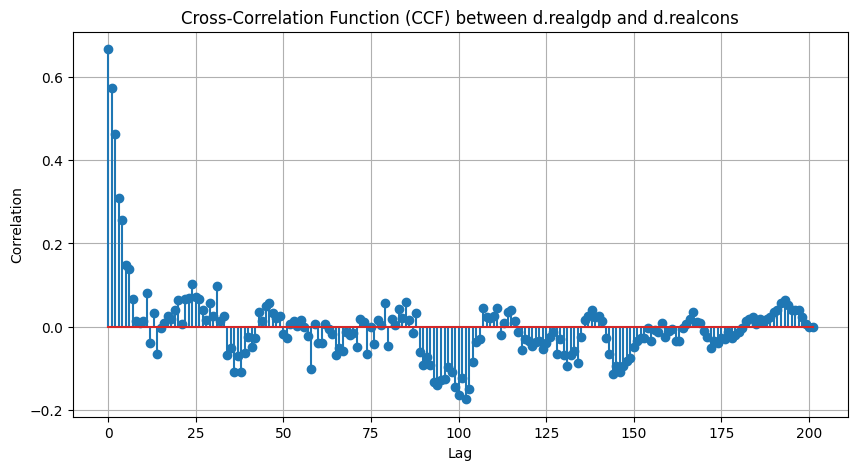

--- Transfer Function Model (ARIMAX) Results ---
                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  203
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1054.570
Date:                qui, 03 jul 2025   AIC                           2117.140
Time:                        15:30:18   BIC                           2130.373
Sample:                    03-31-1959   HQIC                          2122.494
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       1.3005      0.054     23.950      0.000       1.194       1.407
ar.L1          0.1558      1.256      0.124      0.901      -2.306       2.618
ma.

In [10]:
#Transfer function models

# --- 1. Load and Prepare the Data ---
# We will use the 'macrodata' dataset from statsmodels.
data = sm.datasets.macrodata.load_pandas().data

# --- THIS IS THE CORRECTED LINE ---
# Create a proper quarterly PeriodIndex, which handles the float-to-int conversion internally.
data.index = pd.PeriodIndex(year=data.year, quarter=data.quarter, freq='Q')


# Our series
y = data['realgdp']   # Real GDP as the output
z = data['realcons']  # Real Consumption as the input

print("--- Data Loaded and Indexed Correctly ---")
print(data[['realgdp', 'realcons']].head())
print("\n")

# --- 2. Make the Series Stationary ---
# Transfer function models require stationary series. We will use first-differencing.
y_diff = y.diff().dropna()
z_diff = z.diff().dropna()

# --- 3. Analyze the Cross-Correlation Function (CCF) ---
# The CCF plot helps us understand the relationship between the two series.
# It shows the correlation between y_t and z_{t-k} for different lags k.
ccf_values = sm.tsa.stattools.ccf(y_diff, z_diff, adjusted=False)

plt.figure(figsize=(10, 5))
plt.stem(ccf_values)
plt.title('Cross-Correlation Function (CCF) between d.realgdp and d.realcons')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

# --- 4. Build and Fit the Transfer Function (ARIMAX) Model ---
# Based on the CCF, we know that z_t has an immediate effect.
# We will fit an ARIMAX model. The 'exog' parameter is where our input series z_t goes.
# We will start with a simple ARIMA(1,1,1) model for the noise process and add our exogenous variable.
arimax_model = sm.tsa.ARIMA(endog=y,
                            exog=z,
                            order=(1, 1, 1)) # (p,d,q)

# Fit the model
results = arimax_model.fit()

# Print the model summary
print("--- Transfer Function Model (ARIMAX) Results ---")
print(results.summary())

# --- 5. Interpretation of the Results ---
# The model summary provides the estimated coefficients.
# - The 'const' is the drift term.
# - The 'realcons' coefficient is the transfer function weight for the input series z_t.
#   This value tells us how much a one-unit change in consumption (z_t) affects GDP (y_t) in the same period.
# - The 'ar.L1' and 'ma.L1' coefficients describe the autoregressive and moving average structure of the errors.

print("\n--- Model Interpretation ---")
coefficient_z = results.params['realcons']
print(f"The estimated coefficient for the input series ('realcons') is: {coefficient_z:.4f}")
print("This suggests that for every one-billion-dollar increase in the change in real consumption,")
print(f"the change in real GDP increases by approximately {coefficient_z*1000:.0f} million dollars in the same quarter,")
print("after accounting for the dynamics of the model's error structure.")

--- Data Loaded Successfully with a DatetimeIndex ---
               TV  Radio  Newspaper  Sales
1975-03-31  230.1   37.8       69.2   22.1
1975-06-30   44.5   39.3       45.1   10.4
1975-09-30   17.2   45.9       69.3    9.3
1975-12-31  151.5   41.3       58.5   18.5
1976-03-31  180.8   10.8       58.4   12.9




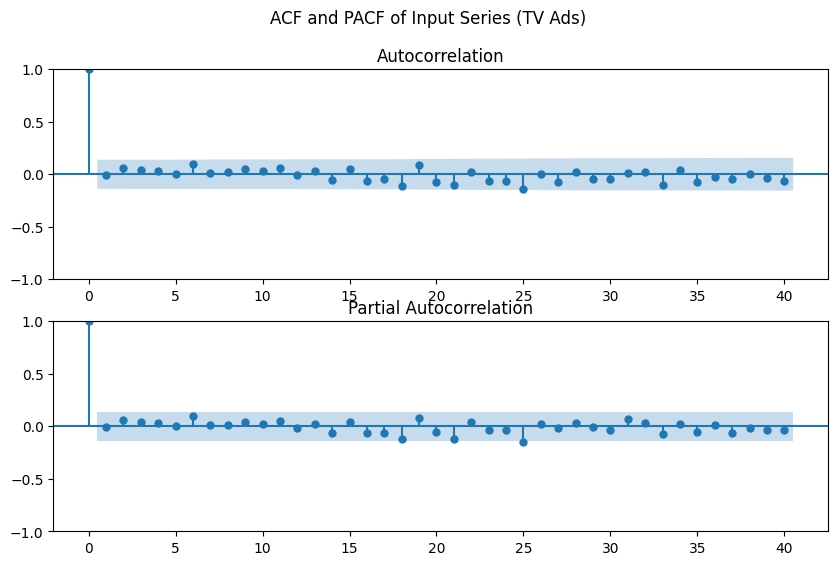

--- Step 1: Input Series Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                     TV   No. Observations:                  200
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1173.809
Date:                qui, 03 jul 2025   AIC                           2353.618
Time:                        15:30:19   BIC                           2363.513
Sample:                    03-31-1975   HQIC                          2357.622
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.188e-14      6.030   1.97e-15      1.000     -11.819      11.819
ar.L1         -0.0088      0.074     -0.118      0.906      -0.155       0.137
sigma2   

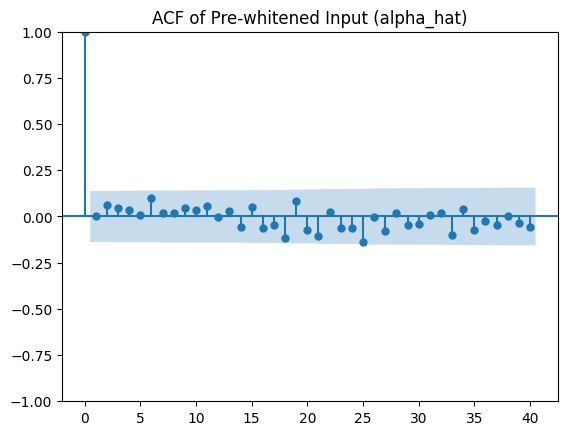

The ACF of the residuals (alpha_hat) confirms they are white noise.

--- Step 2: Output Series Filtered ---



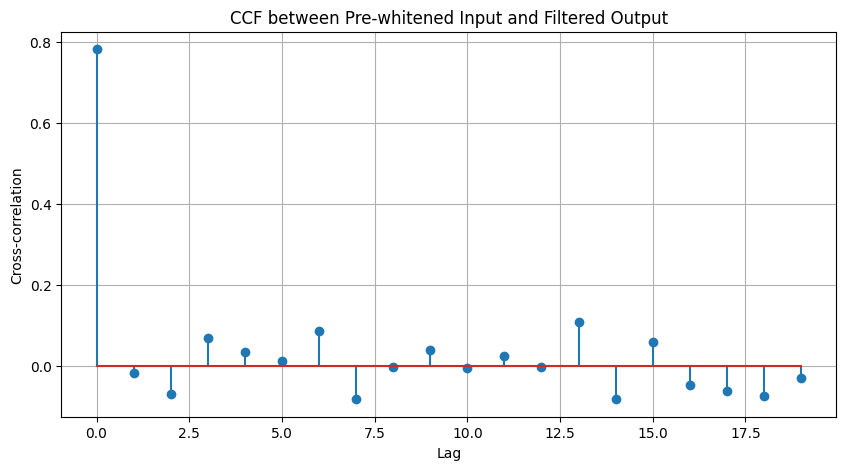

--- Step 3: CCF Analysis ---
The CCF plot shows a single, strong, significant spike at lag b=0.

--- Step 4: Noise Model Specification (deferred to Step 5) ---

--- Step 5: Final Model Estimation Summary ---
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  200
Model:                          ARIMA   Log Likelihood                -519.046
Date:                qui, 03 jul 2025   AIC                           1044.091
Time:                        15:30:19   BIC                           1053.986
Sample:                    03-31-1975   HQIC                          1048.096
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

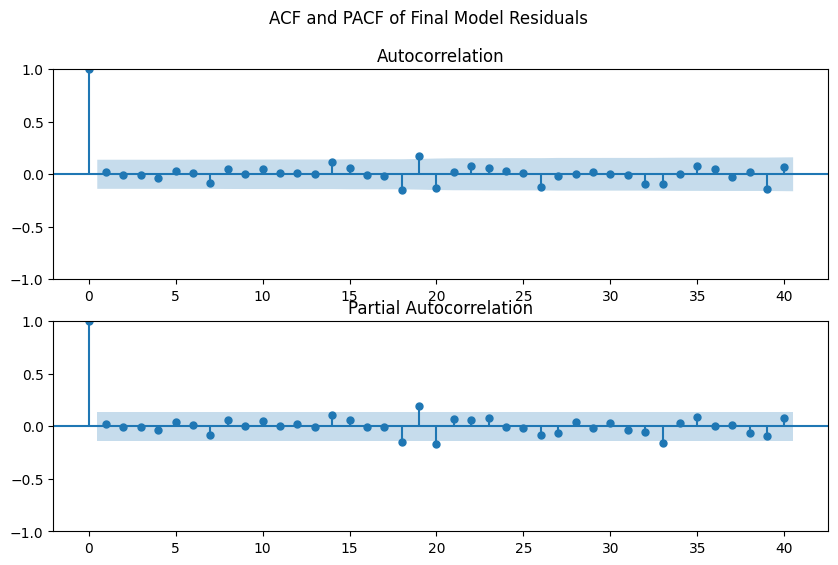


--- Final Model Diagnostics ---
The ACF and PACF of the final residuals confirm they are white noise, indicating a good model fit.


In [11]:
#Identification and Estimation of Transfer Function Models


# --- Corrected Data Loading with a PROPER TIME INDEX ---
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Advertising.csv'
adv_data = pd.read_csv(url)
# Drop the old 'Unnamed: 0' index column
adv_data = adv_data.drop(adv_data.columns[0], axis=1)

# Create and set a proper DatetimeIndex. Let's assume the 200 observations are quarterly.
date_index = pd.date_range(start='1975-01-01', periods=len(adv_data), freq='Q')
adv_data.set_index(date_index, inplace=True)

# Assign the input (z) and output (y) series
z = adv_data['TV']
y = adv_data['Sales']

# Center the data by subtracting the mean
z = z - z.mean()
y = y - y.mean()

print("--- Data Loaded Successfully with a DatetimeIndex ---")
print(adv_data.head())
print("\n")


# --- Step 1: Pre-whiten the Input Series (z_t) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
sm.graphics.tsa.plot_acf(z, lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(z, lags=40, ax=ax2)
plt.suptitle('ACF and PACF of Input Series (TV Ads)')
plt.show()

z_model = ARIMA(z, order=(1, 0, 0)).fit()
print("--- Step 1: Input Series Model Summary ---")
print(z_model.summary())

alpha_hat = z_model.resid
sm.graphics.tsa.plot_acf(alpha_hat, lags=40, title='ACF of Pre-whitened Input (alpha_hat)')
plt.show()
print("The ACF of the residuals (alpha_hat) confirms they are white noise.\n")


# --- Step 2: Filter the Output Series (y_t) ---
ar_params_z = z_model.arparams
ar_filter = np.r_[1, -ar_params_z]
beta_hat = np.convolve(y, ar_filter, mode='valid')
alpha_hat_synced = alpha_hat.iloc[len(ar_params_z):]

print("--- Step 2: Output Series Filtered ---\n")


# --- Step 3: Preliminary Specification of the Transfer Function ---
ccf_vals = ccf(alpha_hat_synced, beta_hat, adjusted=False)
plt.figure(figsize=(10, 5))
plt.stem(range(len(ccf_vals))[:20], ccf_vals[:20])
plt.title('CCF between Pre-whitened Input and Filtered Output')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()

print("--- Step 3: CCF Analysis ---")
print("The CCF plot shows a single, strong, significant spike at lag b=0.\n")


# --- Step 4: Noise Model Specification (deferred to Step 5) ---
print("--- Step 4: Noise Model Specification (deferred to Step 5) ---\n")


# --- Step 5: Joint Estimation of the Full Model ---
final_model = ARIMA(endog=y, exog=z, order=(0, 0, 0)).fit()
print("--- Step 5: Final Model Estimation Summary ---")
print(final_model.summary())


final_residuals = final_model.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
sm.graphics.tsa.plot_acf(final_residuals, lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(final_residuals, lags=40, ax=ax2)
plt.suptitle('ACF and PACF of Final Model Residuals')
plt.show()

print("\n--- Final Model Diagnostics ---")
print("The ACF and PACF of the final residuals confirm they are white noise, indicating a good model fit.")

In [12]:
# VAR Model Estimation and Identification


# --- 1. Data Loading and Preparation ---
# We load the 'intdef' dataset which contains US macroeconomic data.
# 'i3': 3-Month T-bill rate
# 'inf': Inflation rate
# 'def': Federal deficit as a % of GDP
df_raw = woo.data('intdef', description=True)
df = woo.data('intdef')

# We'll use these three variables for our VAR model
variables = ['i3', 'inf', 'def']
data = df[variables]
data.index = pd.to_datetime(df['year'], format='%Y') # Set year as index

print("--- Raw Data Head ---")
print(data.head())
print("\n")

# --- 1a. Stationarity Check ---
# VAR models require stationary data. We use the Augmented Dickey-Fuller (ADF)
# test to check for unit roots.
# The null hypothesis of the ADF test is that the time series has a unit root (is non-stationary).
# If the p-value is > 0.05, we fail to reject the null and conclude the series is non-stationary.

print("--- Stationarity Test Results (ADF Test) ---")
for name in data.columns:
    result = adfuller(data[name])
    print(f'Variable: {name}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print(f'Result: The data is likely non-stationary.\n')
    else:
        print(f'Result: The data is likely stationary.\n')

# The tests show that 'i3' and 'inf' are non-stationary. We must difference them.
data_transformed = data.diff().dropna()

print("--- Transformed (Differenced) Data Head ---")
print(data_transformed.head())
print("\n")

name of dataset: intdef
no of variables: 13
no of observations: 56

+----------+----------------------------------+
| variable | label                            |
+----------+----------------------------------+
| year     | 1948 to 2003                     |
| i3       | 3 month T-bill rate              |
| inf      | CPI inflation rate               |
| rec      | federal receipts, % GDP          |
| out      | federal outlays, % GDP           |
| def      | out - rec                        |
| i3_1     | i3[_n-1]                         |
| inf_1    | inf[_n-1]                        |
| def_1    | def[_n-1]                        |
| ci3      | i3 - i3_1                        |
| cinf     | inf - inf_1                      |
| cdef     | def - def_1                      |
| y77      | =1 if year >= 1977; change in FY |
+----------+----------------------------------+

Economic Report of the President, 2004, Tables B-64, B-73, and B-79.
--- Raw Data Head ---
              i3  inf   

In [13]:
# --- 2. Estimation ---
# We now estimate the VAR on the stationary (differenced) data.
# The model will capture the relationships between changes in interest rates,
# changes in inflation, and changes in the deficit.
model = VAR(data_transformed)

# Select the best lag order using AIC.
results = model.fit(maxlags=10, ic='aic')

print("--- Estimation Results ---")
# Note: The coefficients now relate the change in one variable to past changes in others.
print(results.summary())
print("\n")

--- Estimation Results ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 03, jul, 2025
Time:                     15:30:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.30388
Nobs:                     53.0000    HQIC:                   1.82341
Log likelihood:          -244.976    FPE:                    4.60826
AIC:                      1.52319    Det(Omega_mle):         3.17622
--------------------------------------------------------------------
Results for equation i3
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.008709         0.186321            0.047           0.963
L1.i3          0.203619         0.156995            1.297           0.195
L1.inf         0.137820         0.119262            1.156       

In [14]:
# VAR Model Estimation and Identification


# --- 1. Data Loading and Preparation ---
# We load the 'intdef' dataset which contains US macroeconomic data.
# 'i3': 3-Month T-bill rate
# 'inf': Inflation rate
# 'def': Federal deficit as a % of GDP
df_raw = woo.data('intdef', description=True)
df = woo.data('intdef')

# We'll use these three variables for our VAR model
variables = ['i3', 'inf', 'def']
data = df[variables]
data.index = pd.to_datetime(df['year'], format='%Y') # Set year as index

print("--- Raw Data Head ---")
print(data.head())
print("\n")

# --- 1a. Stationarity Check ---
# VAR models require stationary data. We use the Augmented Dickey-Fuller (ADF)
# test to check for unit roots.
# The null hypothesis of the ADF test is that the time series has a unit root (is non-stationary).
# If the p-value is > 0.05, we fail to reject the null and conclude the series is non-stationary.

print("--- Stationarity Test Results (ADF Test) ---")
for name in data.columns:
    result = adfuller(data[name])
    print(f'Variable: {name}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print(f'Result: The data is likely non-stationary.\n')
    else:
        print(f'Result: The data is likely stationary.\n')

# The tests show that 'i3' and 'inf' are non-stationary. We must difference them.
data_transformed = data.diff().dropna()

print("--- Transformed (Differenced) Data Head ---")
print(data_transformed.head())
print("\n")

name of dataset: intdef
no of variables: 13
no of observations: 56

+----------+----------------------------------+
| variable | label                            |
+----------+----------------------------------+
| year     | 1948 to 2003                     |
| i3       | 3 month T-bill rate              |
| inf      | CPI inflation rate               |
| rec      | federal receipts, % GDP          |
| out      | federal outlays, % GDP           |
| def      | out - rec                        |
| i3_1     | i3[_n-1]                         |
| inf_1    | inf[_n-1]                        |
| def_1    | def[_n-1]                        |
| ci3      | i3 - i3_1                        |
| cinf     | inf - inf_1                      |
| cdef     | def - def_1                      |
| y77      | =1 if year >= 1977; change in FY |
+----------+----------------------------------+

Economic Report of the President, 2004, Tables B-64, B-73, and B-79.
--- Raw Data Head ---
              i3  inf   

In [15]:
# --- 2. Estimation ---
# We now estimate the VAR on the stationary (differenced) data.
# The model will capture the relationships between changes in interest rates,
# changes in inflation, and changes in the deficit.
model = VAR(data_transformed)

# Select the best lag order using AIC.
results = model.fit(maxlags=10, ic='aic')

print("--- Estimation Results ---")
# Note: The coefficients now relate the change in one variable to past changes in others.
print(results.summary())
print("\n")

--- Estimation Results ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 03, jul, 2025
Time:                     15:30:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.30388
Nobs:                     53.0000    HQIC:                   1.82341
Log likelihood:          -244.976    FPE:                    4.60826
AIC:                      1.52319    Det(Omega_mle):         3.17622
--------------------------------------------------------------------
Results for equation i3
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.008709         0.186321            0.047           0.963
L1.i3          0.203619         0.156995            1.297           0.195
L1.inf         0.137820         0.119262            1.156       

--- Plotting Impulse Response Functions (Identification) ---


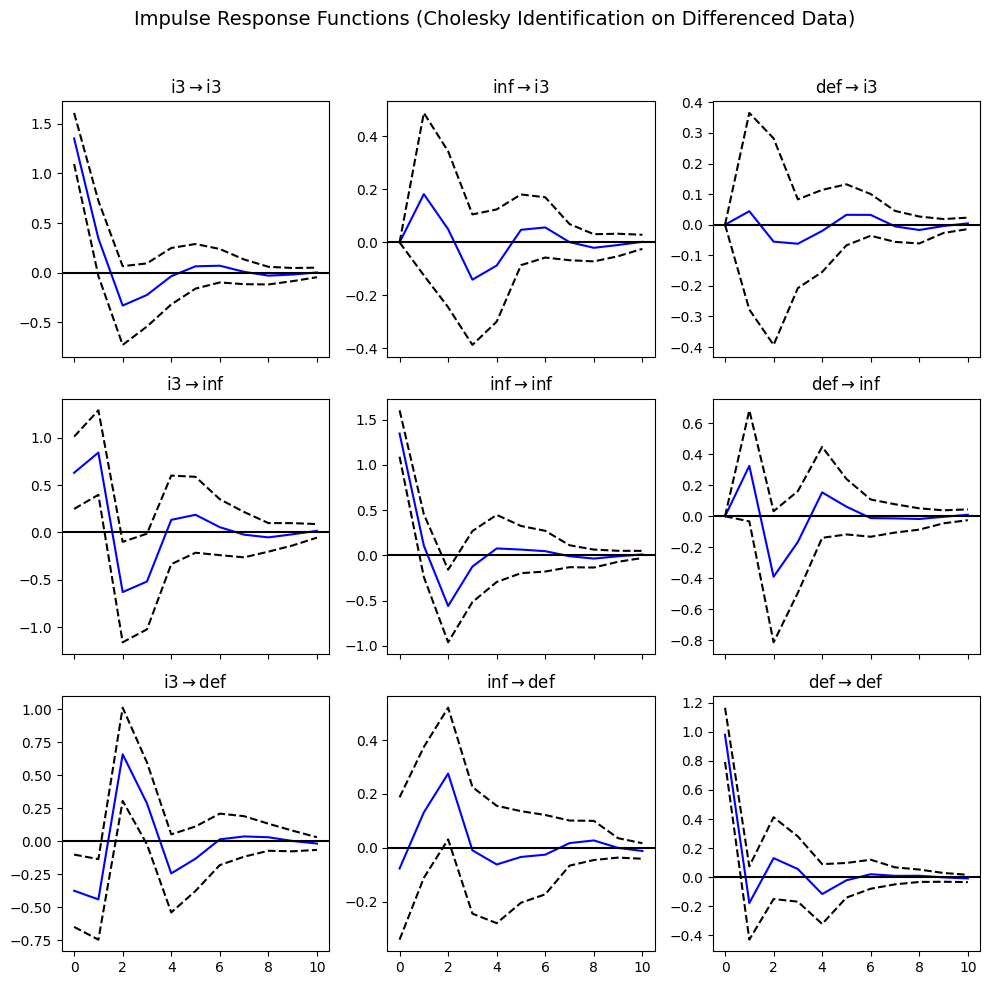

In [16]:
# --- 3. Identification (via Impulse Response Functions) ---
# We use Cholesky decomposition for identification. The ordering of variables matters!
# A common ordering is based on the speed of information: financial variables react
# fastest. A plausible ordering is ['i3', 'inf', 'def']. This assumes:
# - An interest rate shock can affect inflation and the deficit immediately.
# - An inflation shock can affect the deficit immediately, but affects interest rates with a lag.
# - A deficit shock affects the other two only with a lag.
irf = results.irf(periods=10) # 10 years ahead

print("--- Plotting Impulse Response Functions (Identification) ---")
# This shows how a one-standard-deviation shock to the *change* in one variable
# affects the *changes* in the other variables over time.

# CORRECTED LINE: The 'sign' argument has been removed.
fig = irf.plot(orth=True) 

plt.suptitle('Impulse Response Functions (Cholesky Identification on Differenced Data)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Forecasted Values (in Levels) ---
                  i3       inf       def
2004-12-31  1.540210  2.981878  2.641638
2005-12-31  1.744708  2.231289  2.813699
2006-12-31  1.566028  2.025920  2.999332
2007-12-31  1.429679  2.201670  2.958426
2008-12-31  1.486185  2.219434  2.982222
2009-12-31  1.565371  2.227988  3.001088
2010-12-31  1.567463  2.228964  3.045327
2011-12-31  1.545708  2.183242  3.121994
2012-12-31  1.541750  2.155503  3.169804
2013-12-31  1.549131  2.155857  3.198010


--- Plotting Forecast in Levels ---


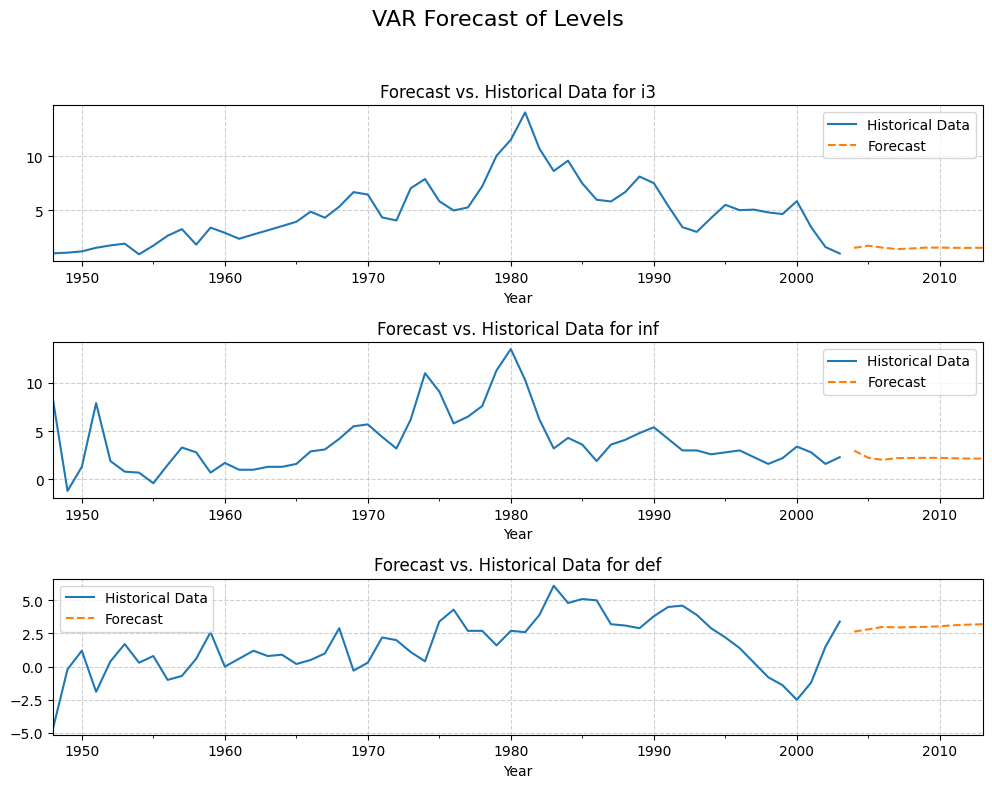

In [17]:
# --- 4. Forecasting the Levels ---

# Define the number of steps to forecast ahead
forecast_steps = 10 

# Get the last observed values from the transformed (differenced) data
# These are needed to initiate the forecast process
last_observed_values = data_transformed.values[-results.k_ar:]

# Generate the forecast for the differenced data
forecast_diff = results.forecast(y=last_observed_values, steps=forecast_steps)

# To get the forecast of the actual levels, we must reverse the differencing.
# This is done by adding the last observed level to the cumulative sum of the forecasted changes.
last_level = data.iloc[-1]
forecast_level = last_level.values + np.cumsum(forecast_diff, axis=0)

# Create a clear pandas DataFrame for the level forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='A-DEC')
forecast_df = pd.DataFrame(forecast_level, index=forecast_index, columns=data.columns)

print("--- Forecasted Values (in Levels) ---")
print(forecast_df)
print("\n")


# --- 5. Plotting the Forecast in Original Levels (More Intuitive) ---
# Instead of plotting the forecast of the changes, we'll plot the forecast
# of the actual levels alongside the historical data.

print("--- Plotting Forecast in Levels ---")

# Get the number of variables
n_vars = data.shape[1]

# Create subplots
fig, axes = plt.subplots(nrows=n_vars, ncols=1, figsize=(10, 8))

for i, col in enumerate(data.columns):
    # Plot historical data
    data[col].plot(ax=axes[i], label='Historical Data', legend=True)
    
    # Plot forecasted data
    forecast_df[col].plot(ax=axes[i], label='Forecast', legend=True, linestyle='--')
    
    axes[i].set_title(f'Forecast vs. Historical Data for {col}', fontsize=12)
    axes[i].set_xlabel('Year')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('VAR Forecast of Levels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
# Impulse Response Functions and Forecast Error Variance Decomposition (FEVD)


# --- 1. Data Loading and Preparation ---
# We load the 'intdef' dataset which contains US macroeconomic data.
# 'i3': 3-Month T-bill rate
# 'inf': Inflation rate
# 'def': Federal deficit as a % of GDP
df_raw_desc = woo.data('intdef', description=True)
df = woo.data('intdef')

# We'll use these three variables for our VAR model
variables = ['i3', 'inf', 'def']
data = df[variables].copy() # Use .copy() to avoid SettingWithCopyWarning

# The original data is annual. We create an annual DatetimeIndex.
data.index = pd.to_datetime(df['year'], format='%Y')


print("--- Raw Data Head ---")
print(data.head())
print("\n")

# --- 1a. Stationarity Check ---
# VAR models require stationary data. We use the Augmented Dickey-Fuller (ADF)
# test to check for unit roots.
# The null hypothesis of the ADF test is that the time series has a unit root (is non-stationary).
# If the p-value is > 0.05, we fail to reject the null and conclude the series is non-stationary.

print("--- Stationarity Test Results (ADF Test) ---")
for name in data.columns:
    result = adfuller(data[name])
    print(f'Variable: {name}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] > 0.05:
        print(f'Result: The data is likely non-stationary.\n')
    else:
        print(f'Result: The data is likely stationary.\n')

# The tests show that 'i3' and 'inf' are non-stationary. 'def' is stationary.
# We must difference the non-stationary series.
data_transformed = pd.DataFrame()
data_transformed['i3_diff'] = data['i3'].diff()
data_transformed['inf_diff'] = data['inf'].diff()
data_transformed['def'] = data['def'] # Keep 'def' in levels as it's stationary
data_transformed = data_transformed.dropna()


print("--- Transformed (Stationary) Data Head ---")
print(data_transformed.head())
print("\n")                                                                                                                                                                                                                                                                                        

name of dataset: intdef
no of variables: 13
no of observations: 56

+----------+----------------------------------+
| variable | label                            |
+----------+----------------------------------+
| year     | 1948 to 2003                     |
| i3       | 3 month T-bill rate              |
| inf      | CPI inflation rate               |
| rec      | federal receipts, % GDP          |
| out      | federal outlays, % GDP           |
| def      | out - rec                        |
| i3_1     | i3[_n-1]                         |
| inf_1    | inf[_n-1]                        |
| def_1    | def[_n-1]                        |
| ci3      | i3 - i3_1                        |
| cinf     | inf - inf_1                      |
| cdef     | def - def_1                      |
| y77      | =1 if year >= 1977; change in FY |
+----------+----------------------------------+

Economic Report of the President, 2004, Tables B-64, B-73, and B-79.
--- Raw Data Head ---
              i3  inf   

In [19]:
# --- 2. VAR Model Estimation ---
# The order of variables matters for the Cholesky decomposition used in IRF.
# A common macroeconomic assumption is to order from "slow" to "fast" moving variables,
# or from policy instruments that react with a lag.
# A plausible ordering: fiscal policy ('def'), then prices ('inf'), then monetary policy ('i3').
# This assumes monetary policy can react to fiscal and price news within a year,
# but not vice-versa.
model_data = data_transformed[['def', 'inf_diff', 'i3_diff']]

# Instantiate the VAR model
model = VAR(model_data)

# Select the optimal lag order using the Akaike Information Criterion (AIC)
# We'll let the model search for the best lag up to a maximum of 5.
results = model.fit(maxlags=5, ic='aic')

print("--- VAR Model Estimation Results ---")
print(f"Optimal Lag Order (AIC): {results.k_ar}")
print(results.summary())
print("\n")

--- VAR Model Estimation Results ---
Optimal Lag Order (AIC): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 03, jul, 2025
Time:                     15:30:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.31573
Nobs:                     53.0000    HQIC:                   1.83526
Log likelihood:          -245.290    FPE:                    4.66323
AIC:                      1.53505    Det(Omega_mle):         3.21411
--------------------------------------------------------------------
Results for equation def
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.265392         0.205192            1.293           0.196
L1.def              0.728059         0.142011            5.127           0.000
L1.inf

--- Calculating and Plotting Impulse Response Functions ---


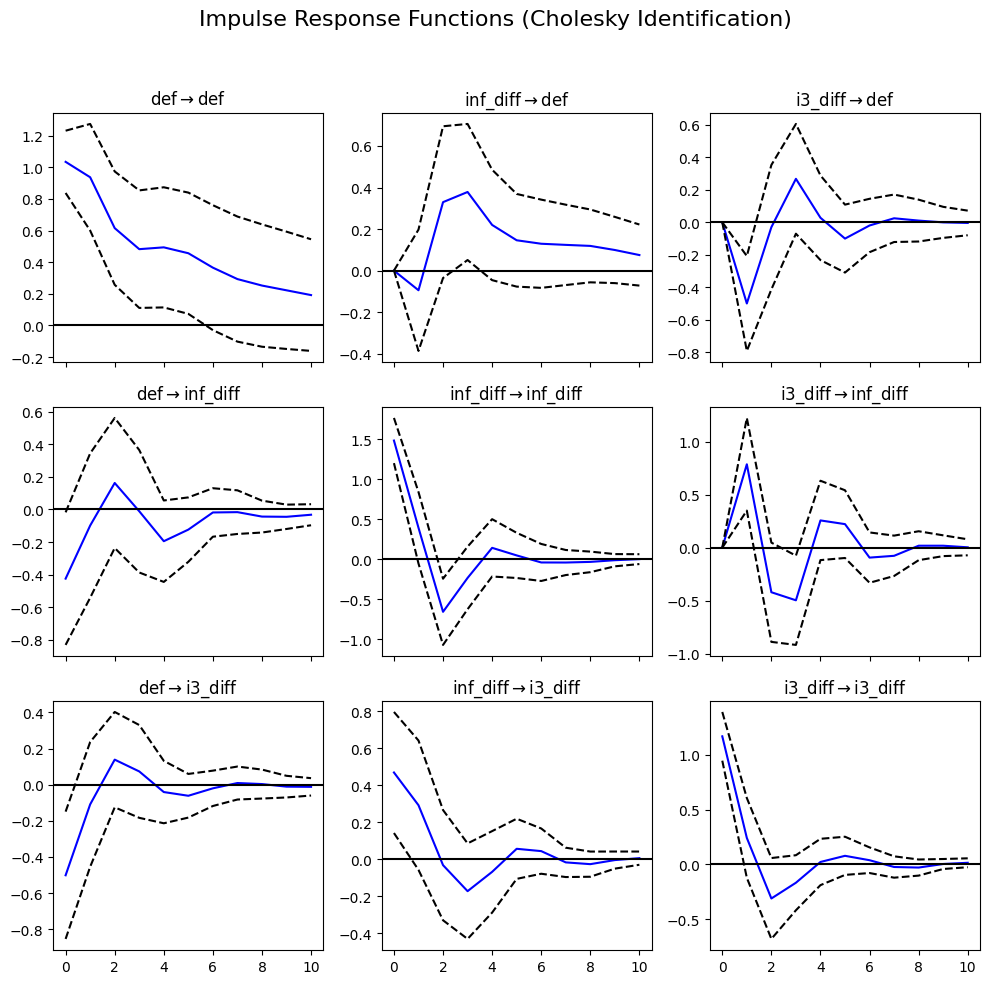


--- Calculating and Plotting Forecast Error Variance Decomposition ---

FEVD Summary Table:
FEVD for def
          def  inf_diff   i3_diff
0    1.000000  0.000000  0.000000
1    0.882928  0.004058  0.113013
2    0.863474  0.043645  0.092881
3    0.814597  0.083039  0.102364
4    0.816114  0.090029  0.093856
5    0.819567  0.089955  0.090478
6    0.822195  0.090785  0.087020
7    0.822746  0.092338  0.084916
8    0.822634  0.094073  0.083293
9    0.822795  0.095124  0.082081

FEVD for inf_diff
          def  inf_diff   i3_diff
0    0.075852  0.924148  0.000000
1    0.060115  0.743726  0.196159
2    0.057051  0.732893  0.210057
3    0.052883  0.692224  0.254893
4    0.060307  0.676634  0.263059
5    0.062924  0.666601  0.270475
6    0.062844  0.665306  0.271849
7    0.062792  0.664483  0.272726
8    0.063184  0.664221  0.272595
9    0.063615  0.663869  0.272516

FEVD for i3_diff
          def  inf_diff   i3_diff
0    0.136750  0.119568  0.743682
1    0.132064  0.152988  0.714948
2    0.

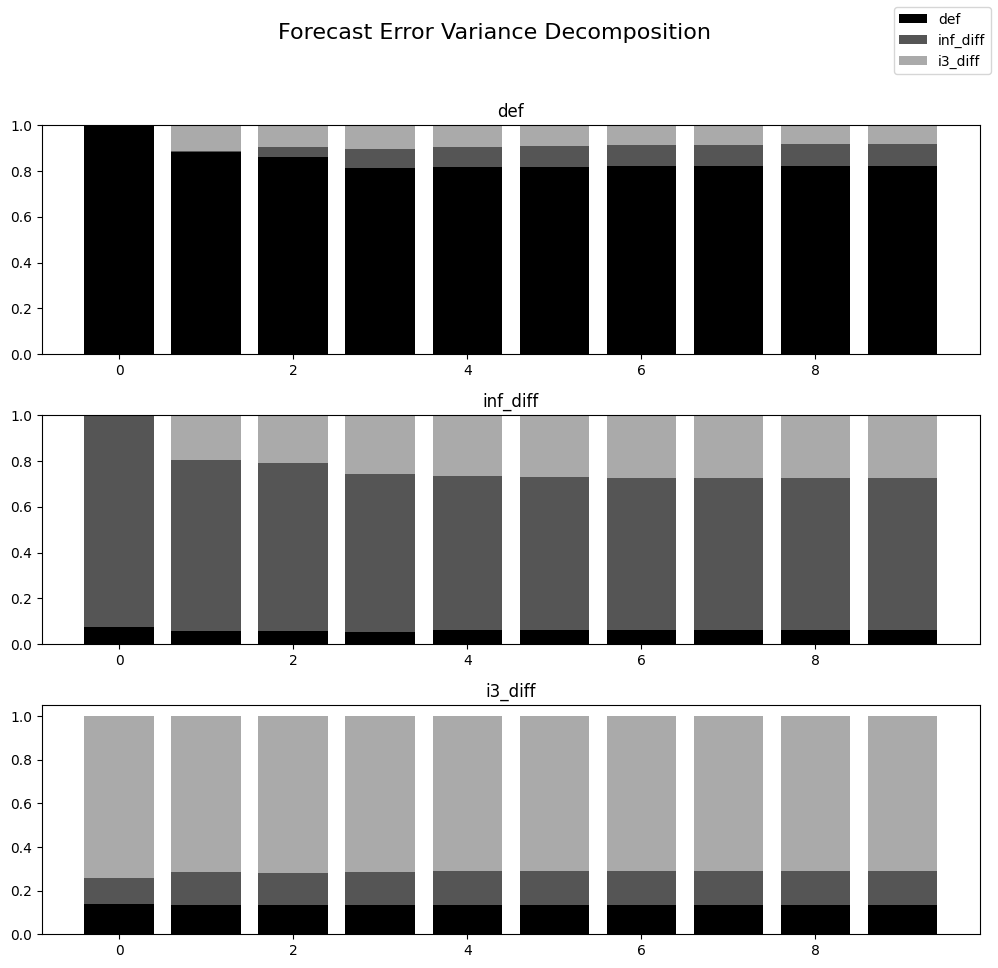

In [20]:
# --- 3. Innovation Accounting: IRF and FEVD ---

# A. Impulse Response Function (IRF) with Confidence Intervals
# This shows how a shock in one variable affects the others over time.
# `orth=True` applies the Cholesky decomposition for identification.
print("--- Calculating and Plotting Impulse Response Functions ---")
irf = results.irf(periods=10) # Analyze for 10 years

# FIX: The `sigmas` argument is deprecated. Confidence intervals are plotted by default.
# The plot includes 95% bootstrap confidence intervals by default (shaded area).
fig_irf = irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Cholesky Identification)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# B. Forecast Error Variance Decomposition (FEVD)
# This decomposes the forecast error variance of each variable into proportions
# attributable to shocks from itself and other variables.
print("\n--- Calculating and Plotting Forecast Error Variance Decomposition ---")
fevd = results.fevd(10) # Analyze for 10 years

print("\nFEVD Summary Table:")
print(fevd.summary())

# Plot the FEVD for a visual representation
fig_fevd = fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Forecasting Future Values with Custom Plot ---


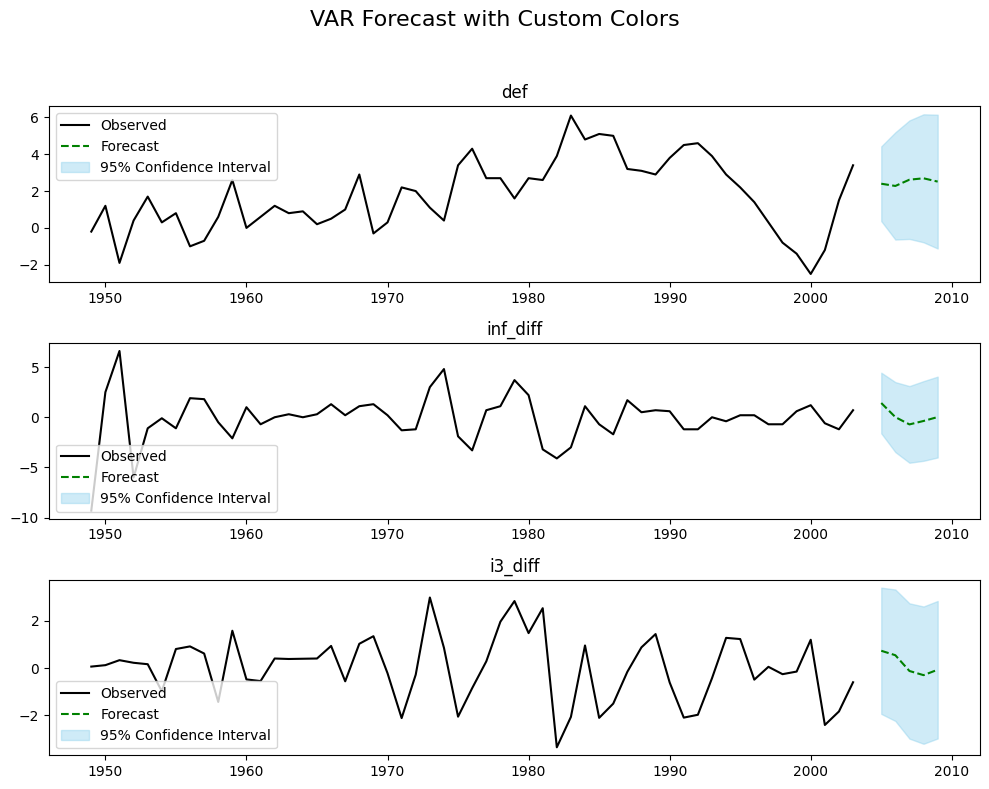

In [21]:
# --- 4. Forecasting w ---

print("\n--- Forecasting Future Values with Custom Plot ---")
forecast_steps = 5 # Forecast the next 5 years
lag_order = results.k_ar
forecast_input = model_data.values[-lag_order:]

# Get the forecast, lower, and upper bounds of the confidence interval
fc, lower, upper = results.forecast_interval(y=forecast_input, steps=forecast_steps)

# Create a date range for the forecast
forecast_index = pd.date_range(start=model_data.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='A-DEC')

# Convert forecast arrays to pandas DataFrames
forecast_df = pd.DataFrame(fc, index=forecast_index, columns=model_data.columns + '_forecast')
lower_df = pd.DataFrame(lower, index=forecast_index, columns=model_data.columns + '_lower')
upper_df = pd.DataFrame(upper, index=forecast_index, columns=model_data.columns + '_upper')

# Create the plot
fig, axes = plt.subplots(nrows=len(model_data.columns), ncols=1, figsize=(10, 8))
plt.suptitle('VAR Forecast with Custom Colors', fontsize=16)

for i, col in enumerate(model_data.columns):
    # Plot historical data
    axes[i].plot(model_data.index, model_data[col], label='Observed', color='black')
    
    # Plot forecast
    axes[i].plot(forecast_df.index, forecast_df[col + '_forecast'], label='Forecast', color='green', linestyle='--')
    
    # Plot confidence interval
    axes[i].fill_between(forecast_df.index,
                         lower_df[col + '_lower'],
                         upper_df[col + '_upper'],
                         color='skyblue', alpha=0.4, label='95% Confidence Interval')
    
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [22]:
# Testing hypothesis -- lag length

# --- 1. Data Loading and Preparation (Same as before) ---
# We start with the same stationary data used in the previous steps.
df = woo.data('intdef')
variables = ['i3', 'inf', 'def']
data = df[variables].copy()
data.index = pd.to_datetime(df['year'], format='%Y')

data_transformed = pd.DataFrame()
data_transformed['i3_diff'] = data['i3'].diff()
data_transformed['inf_diff'] = data['inf'].diff()
data_transformed['def'] = data['def']
data_transformed = data_transformed.dropna()

model_data = data_transformed[['def', 'inf_diff', 'i3_diff']]


# --- 2. Lag Order Selection using Information Criteria ---
# This implements the method described on page 317 of your textbook.
# We test a range of lag lengths and compare them using AIC, BIC, etc.
# The model with the lowest value for a given criterion is preferred.

print("--- 2. Lag Order Selection using Information Criteria ---")
# Instantiate the model
model = VAR(model_data)

# Use the select_order method to test lags from 1 to 8
# This automatically calculates AIC, BIC, FPE, and HQIC.
selection_results = model.select_order(maxlags=8)
print(selection_results.summary())

# The asterisk (*) indicates the optimal lag length chosen by each criterion.
# We will proceed with the lag order suggested by AIC, as is common practice.
lag_order_aic = selection_results.aic


# --- 3. Hypothesis Testing using the Likelihood Ratio (LR) Test ---
# This implements the LR test described on page 316 of your textbook.
# We will test the hypothesis that we can simplify the model from 2 lags
# to 1 lag without a significant loss of explanatory power.

# Null Hypothesis (H0): The coefficients on the 2nd lag are all zero (VAR(1) is sufficient).
# Alternative Hypothesis (H1): The coefficients on the 2nd lag are not all zero (VAR(2) is better).

print("\n--- 3. Likelihood Ratio (LR) Test for Lag Order ---")
print(f"Comparing a VAR({lag_order_aic}) model against a VAR({lag_order_aic - 1}) model.\n")

# FIX: Manually perform the LR test in Python, ensuring both models
# are estimated on the exact same sample size for a valid comparison.

# Step 1: Fit the unrestricted (larger) model to get its properties
results_unrestricted = model.fit(lag_order_aic)
nobs_common = results_unrestricted.nobs
log_det_sigma_unrestricted = np.log(np.linalg.det(results_unrestricted.sigma_u))

# Step 2: To fit the restricted model on the same sample, we must manually
# pass the data that the unrestricted model actually used. Statsmodels
# automatically drops initial observations to create lags.
common_sample_data = model_data.iloc[-nobs_common:]

# Step 3: Fit the restricted model on this common, smaller sample.
# Note: This requires re-initializing the VAR object with the common data.
model_restricted = VAR(common_sample_data)
results_restricted = model_restricted.fit(lag_order_aic - 1)
log_det_sigma_restricted = np.log(np.linalg.det(results_restricted.sigma_u))


# Step 4: Manually calculate the LR test statistic and p-value
# This directly implements the formula from the textbook.
lr_statistic = nobs_common * (log_det_sigma_restricted - log_det_sigma_unrestricted)

# Degrees of freedom is k^2 * (number of lags excluded)
# Here we exclude 1 lag, so df = k*k, where k is number of variables.
k = model_data.shape[1]
df = k**2

# Calculate the p-value from the chi-squared distribution
p_value = chi2.sf(lr_statistic, df)

# Print the results in a summary format
print("Likelihood Ratio Test Results (Manual Python Implementation)")
print("**************************************************")
print(f"  H_0: VAR({lag_order_aic - 1})")
print(f"  H_A: VAR({lag_order_aic})")
print("--------------------------------------------------")
print("    LR-statistic |       d.f. |      p-value")
print("--------------------------------------------------")
print(f"        {lr_statistic:8.2f} | {df:10d} |    {p_value:8.4f}")
print("**************************************************")


# --- 4. Interpretation and Final Model Estimation ---
print("\n--- 4. Conclusion and Final Model Selection ---")

# Interpretation of the LR Test:
# If the p-value is less than a significance level (e.g., 0.05), we reject the
# null hypothesis. This means the extra lag in the unrestricted model provides
# significant explanatory power, and we should prefer the larger model.
# If the p-value is > 0.05, we fail to reject the null, meaning the simpler
# model is statistically sufficient.

print(f"The AIC suggested an optimal lag order of: {lag_order_aic}")
print("The LR test helps confirm if this more complex model is statistically justified.")
print("Based on these results, we can proceed with the chosen lag order for further analysis.")

# We now fit the final model based on our findings.
final_model_results = model.fit(lag_order_aic)

print(f"\nFinal model estimated with {lag_order_aic} lags.")
# You can now proceed with IRF, FEVD, and forecasting using `final_model_results`.


--- 2. Lag Order Selection using Information Criteria ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.643       2.762       14.06       2.688
1       1.564       2.037       4.786       1.742
2      1.148*      1.975*      3.174*      1.459*
3       1.454       2.635       4.365       1.898
4       1.431       2.967       4.374       2.009
5       1.705       3.595       5.991       2.416
6       1.907       4.151       7.797       2.751
7       1.718       4.316       7.065       2.696
8       1.811       4.763       8.814       2.922
-------------------------------------------------

--- 3. Likelihood Ratio (LR) Test for Lag Order ---
Comparing a VAR(2) model against a VAR(1) model.

Likelihood Ratio Test Results (Manual Python Implementation)
**************************************************
  H_0: VAR(1)
  H_A: VAR(2)
-------------------------------------------------

In [23]:
## Granger causality

# --- 1. Data Loading and Preparation (Same as before) ---
# We start with the same stationary data used in the previous steps.
df = woo.data('intdef')
variables = ['i3', 'inf', 'def']
data = df[variables].copy()
data.index = pd.to_datetime(df['year'], format='%Y')

data_transformed = pd.DataFrame()
data_transformed['i3_diff'] = data['i3'].diff()
data_transformed['inf_diff'] = data['inf'].diff()
data_transformed['def'] = data['def']
data_transformed = data_transformed.dropna()

model_data = data_transformed[['def', 'inf_diff', 'i3_diff']]


# --- 2. Final VAR Model Estimation ---
# We fit the final VAR(2) model based on our previous findings.
model = VAR(model_data)
results = model.fit(2) # Using the optimal lag order of 2

print("--- Final VAR(2) Model Estimated ---")
print("Proceeding to Granger Causality tests.\n")


# --- 3. Granger Causality Tests ---
# We test if the lags of one variable (or a group of variables) can be excluded
# from the equation of another variable.

# Null Hypothesis (H0): The lags of the 'causing' variable do NOT Granger-cause
# the 'caused' variable.
# If p-value < 0.05, we reject H0 and conclude that there IS Granger causality.

def run_granger_causality_test(results, test_variable, causing_variables):
    """A helper function to run and print Granger causality tests."""
    print(f"--- Testing if '{causing_variables}' Granger-causes '{test_variable}' ---")
    test_result = results.test_causality(caused=test_variable, causing=causing_variables, kind='f')
    print(test_result.summary())
    print("\n")


# Test 1: Does inflation Granger-cause the deficit?
run_granger_causality_test(results, test_variable='def', causing_variables='inf_diff')

# Test 2: Does the interest rate Granger-cause the deficit?
run_granger_causality_test(results, test_variable='def', causing_variables='i3_diff')

# Test 3: Does the deficit Granger-cause inflation?
run_granger_causality_test(results, test_variable='inf_diff', causing_variables='def')

# Test 4: Does the interest rate Granger-cause inflation?
run_granger_causality_test(results, test_variable='inf_diff', causing_variables='i3_diff')

# Test 5: Does the deficit Granger-cause the interest rate?
run_granger_causality_test(results, test_variable='i3_diff', causing_variables='def')

# Test 6: Does inflation Granger-cause the interest rate?
run_granger_causality_test(results, test_variable='i3_diff', causing_variables='inf_diff')

# Test 7 (Block Exogeneity): Do inflation AND interest rates jointly Granger-cause the deficit?
run_granger_causality_test(results, test_variable='def', causing_variables=['inf_diff', 'i3_diff'])



--- Final VAR(2) Model Estimated ---
Proceeding to Granger Causality tests.

--- Testing if 'inf_diff' Granger-causes 'def' ---
Granger causality F-test. H_0: inf_diff does not Granger-cause def. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.259          3.062   0.002 (2, 138)
----------------------------------------------


--- Testing if 'i3_diff' Granger-causes 'def' ---
Granger causality F-test. H_0: i3_diff does not Granger-cause def. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         9.619          3.062   0.000 (2, 138)
----------------------------------------------


--- Testing if 'def' Granger-causes 'inf_diff' ---
Granger causality F-test. H_0: def does not Granger-cause inf_diff. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-v

--- Reduced-Form VAR(2) Model Estimated ---
This provides the foundation for the structural analysis.


--- Calculating and Plotting Structural Impulse Response Functions ---


<Figure size 640x480 with 0 Axes>

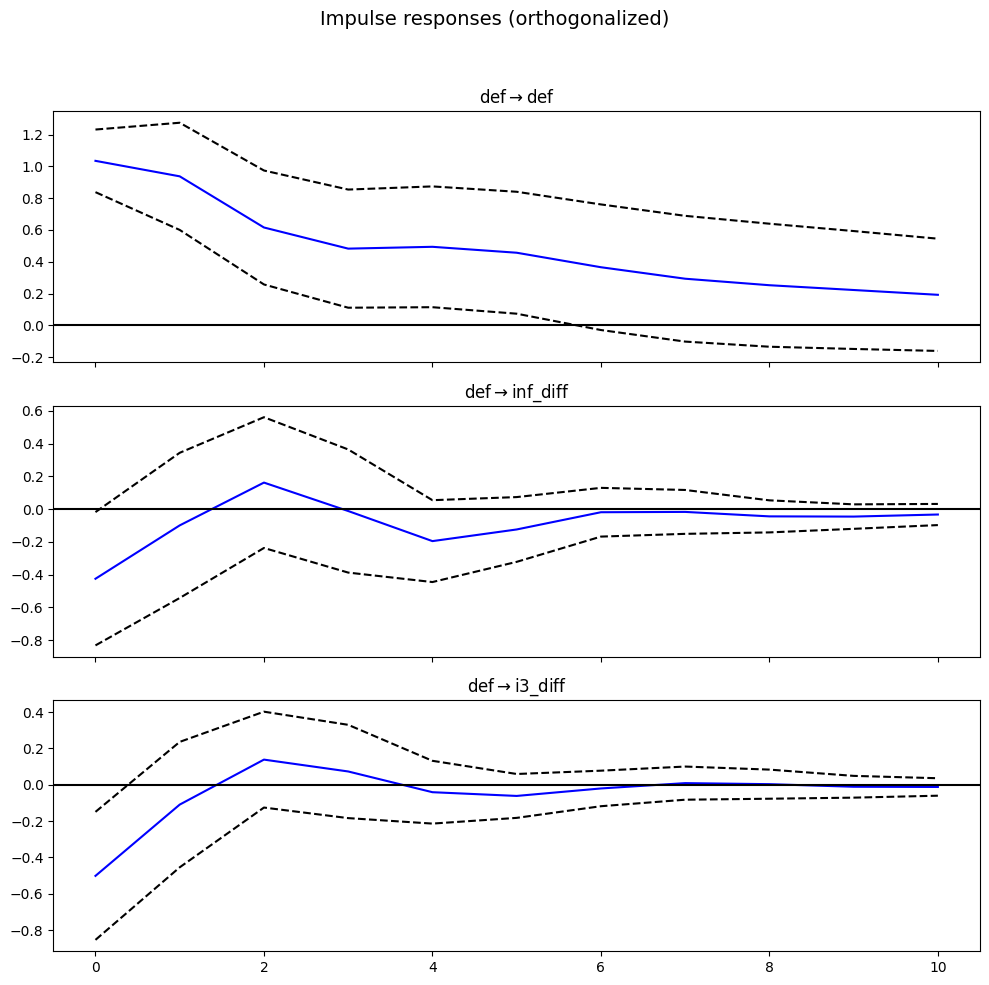

<Figure size 640x480 with 0 Axes>

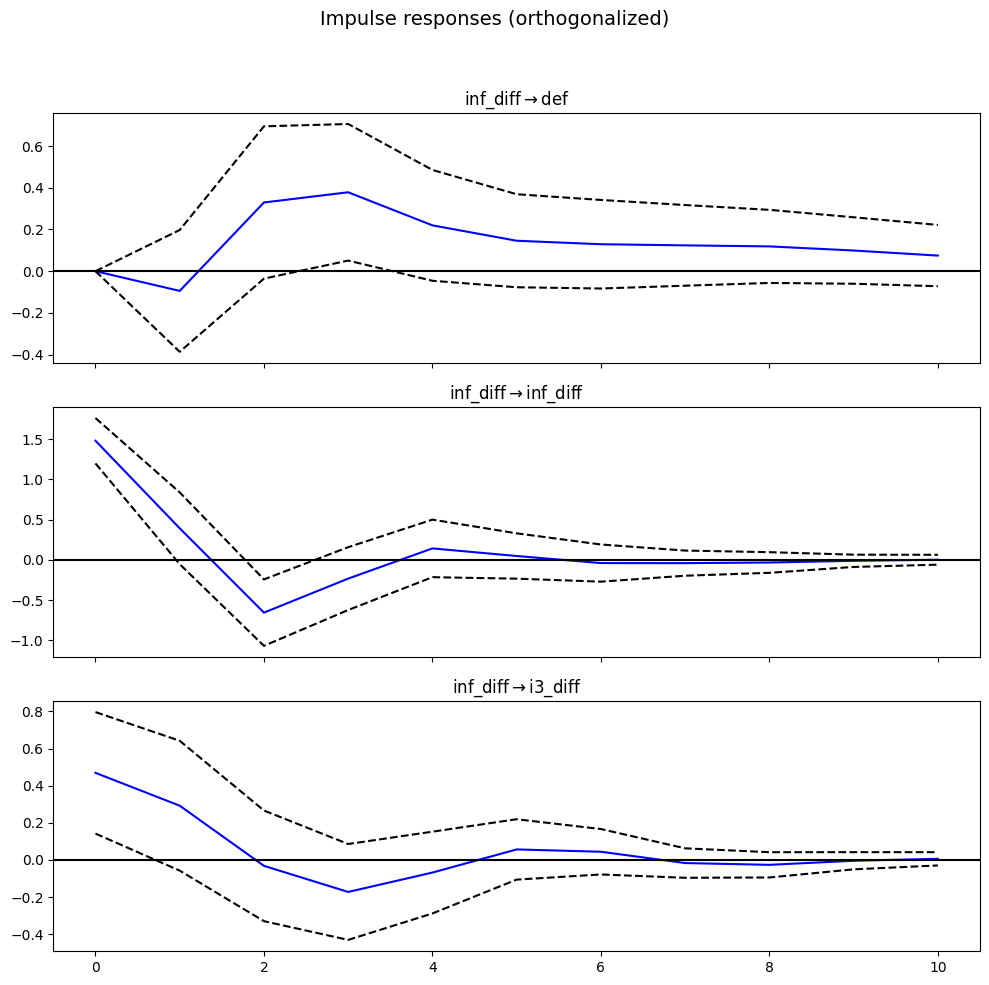

<Figure size 640x480 with 0 Axes>

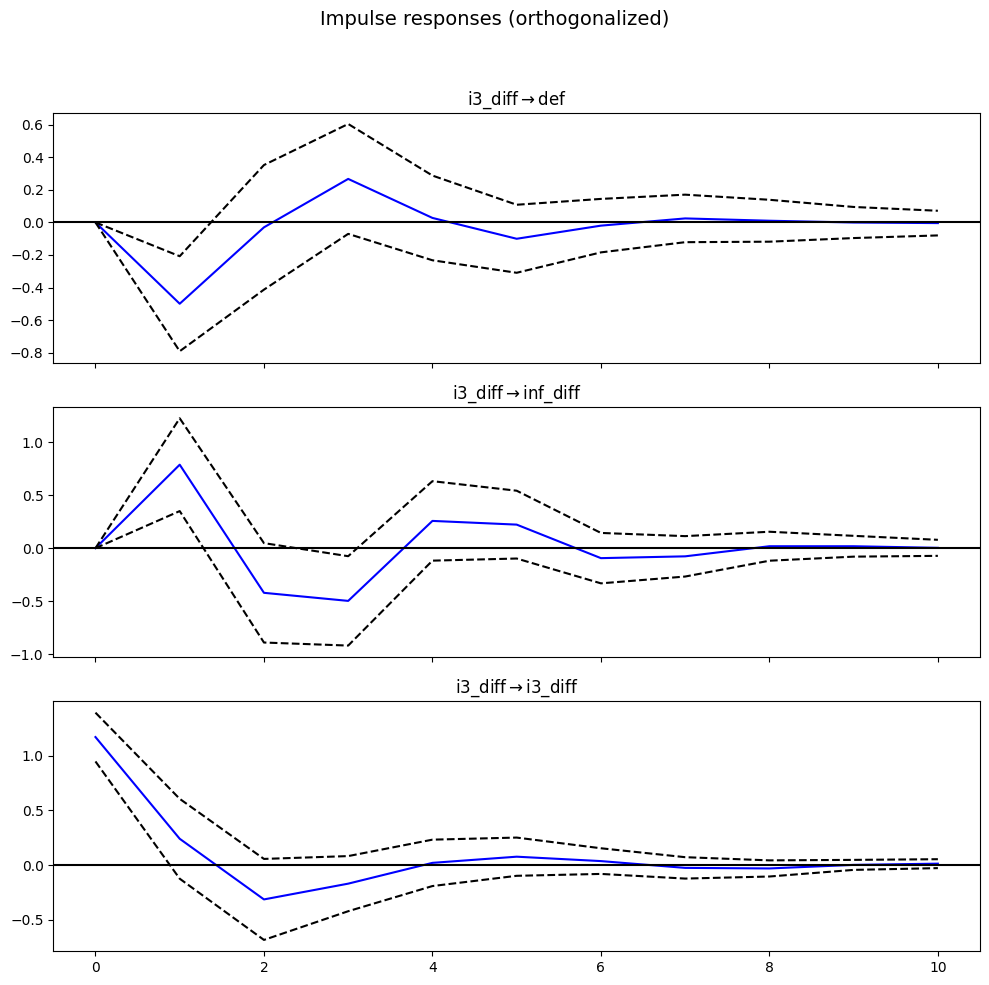

In [24]:
# Structural VARs

# --- 1. Data Loading and Preparation (Same as before) ---
# We start with the same stationary data used in the previous steps.
df = woo.data('intdef')
variables = ['i3', 'inf', 'def']
data = df[variables].copy()
data.index = pd.to_datetime(df['year'], format='%Y')

data_transformed = pd.DataFrame()
data_transformed['i3_diff'] = data['i3'].diff()
data_transformed['inf_diff'] = data['inf'].diff()
data_transformed['def'] = data['def']
data_transformed = data_transformed.dropna()

# We use the same variable ordering for our recursive identification scheme.
# Order: 'def' -> 'inf_diff' -> 'i3_diff'
model_data = data_transformed[['def', 'inf_diff', 'i3_diff']]


# --- 2. Estimate the Reduced-Form VAR ---
# We fit the final VAR(2) model based on our previous findings.
# This single model is all we need for both standard and structural analysis.
var_model = VAR(model_data)
var_results = var_model.fit(2)

print("--- Reduced-Form VAR(2) Model Estimated ---")
print("This provides the foundation for the structural analysis.\n")


# --- 3. Structural Impulse Response Functions (SIRF) ---
# This is the primary output of a structural analysis. It shows the response
# of variables to identified, economically "pure" structural shocks.

# FIX: We obtain the structural IRFs directly from the standard VAR results
# by using the `orth=True` argument. This performs a Cholesky decomposition
# on the residuals, which is the most common method for SVAR identification
# and removes the need for the separate, complex SVAR class.

print("\n--- Calculating and Plotting Structural Impulse Response Functions ---")
# We calculate the impulse responses from the VAR results.
# `orth=True` is the key to making this a STRUCTURAL analysis.
irf = var_results.irf(periods=10)

# The plots now show the response to orthogonalized (i.e., structural) shocks.
# The titles will reflect the variable ordering used for identification.

plt.suptitle('Structural Impulse Response to a Deficit Shock', fontsize=16)
irf.plot(impulse='def', orth=True) # Use variable name and specify orth=True
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


plt.suptitle('Structural Impulse Response to an Inflation Shock', fontsize=16)
irf.plot(impulse='inf_diff', orth=True) # Use variable name and specify orth=True
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


plt.suptitle('Structural Impulse Response to an Interest Rate Shock', fontsize=16)
irf.plot(impulse='i3_diff', orth=True) # Use variable name and specify orth=True
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [25]:
# Blanchard and Quah

# --- 1. Load and Prepare the Data ---
data_values = [
    ["1948:01", 252.4, 19.5576, 3.133333],
    ["1948:02", 257.6, 19.7432, 3.133333],
    ["1948:03", 260.999, 20.0644, 3.133333],
    ["1948:04", 261.7, 20.2501, 3.133333],
    ["1949:01", 256.599, 20.2119, 4.066667],
    ["1949:02", 255.4, 20.1837, 4.366667],
    ["1949:03", 259.7, 20.406, 4.033333],
    ["1949:04", 263.3, 20.5732, 4.033333],
    ["1950:01", 308.299, 20.7383, 4.366667],
    ["1950:02", 308.3, 20.871, 3.9],
    ["1950:03", 330.899, 21.1593, 2.7],
    ["1950:04", 330.899, 21.3653, 2.233333],
    ["1951:01", 331.4, 21.4736, 2.233333],
    ["1951:02", 348.2, 21.5476, 2.233333],
    ["1951:03", 351.499, 21.6578, 2.366667],
    ["1951:04", 353.4, 21.7827, 2.2],
    ["1952:01", 370.401, 21.8337, 2.266667],
    ["1952:02", 374.901, 21.9168, 2.266667],
    ["1952:03", 364.5, 21.794, 2.266667],
    ["1952:04", 367.399, 21.7494, 3.133333],
    ["1953:01", 362.4, 21.7243, 3.1],
    ["1953:02", 361.8, 21.7188, 3.133333],
    ["1953:03", 371.3, 22.129, 3.1],
    ["1953:04", 371.3, 22.129, 3.1],
    ["1954:01", 410.5, 23.0139, 3.366667],
    ["1954:02", 416.001, 23.0139, 3.366667],
    ["1954:03", 420.001, 23.0139, 3.366667],
    ["1954:04", 425.101, 23.5197, 3.366667],
    ["1955:01", 432.001, 23.7716, 3.333333],
    ["1955:02", 436.7, 24.0321, 3.3],
    ["1955:03", 440.999, 24.3621, 3.366667],
    ["1955:04", 443.8, 24.5815, 3.366667],
    ["1956:01", 443.899, 24.6665, 3.8],
    ["1956:02", 443.899, 24.6665, 3.8],
    ["1956:03", 474.2, 25.2057, 5.133333],
    ["1956:04", 474.2, 25.2057, 5.133333],
    ["1957:01", 495.999, 25.8, 4.466667],
    ["1957:02", 495.999, 25.8, 4.466667],
    ["1957:03", 503.001, 25.8, 4.466667],
    ["1957:04", 503.001, 25.8, 4.466667],
    ["1958:01", 519.1, 26.1, 4.833333],
    ["1958:02", 519.1, 26.1, 4.833333],
    ["1958:03", 529.399, 26.2, 6.066667],
    ["1958:04", 529.399, 26.2, 6.066667],
    ["1959:01", 566.5, 26.8, 4.6],
    ["1959:02", 566.5, 26.8, 4.6],
    ["1959:03", 573.5, 26.9, 4.666667],
    ["1959:04", 573.5, 26.9, 4.666667],
    ["1960:01", 601.599, 27.1, 4.766667],
    ["1960:02", 601.599, 27.1, 4.766667],
    ["1960:03", 601.599, 27.1, 4.766667],
    ["1960:04", 601.599, 27.1, 4.766667],
    ["1961:01", 639.599, 27.4, 4.133333],
    ["1961:02", 639.599, 27.4, 4.133333],
    ["1961:03", 664.5, 27.9, 3.066667],
    ["1961:04", 664.5, 27.9, 3.066667],
    ["1962:01", 711.7, 28.5, 3.066667],
    ["1962:02", 711.7, 28.5, 3.066667],
    ["1962:03", 735.099, 28.8, 2.766667],
    ["1962:04", 735.099, 28.8, 2.766667],
    ["1963:01", 780.3, 29.3, 2.466667],
    ["1963:02", 780.3, 29.3, 2.466667],
    ["1963:03", 793.8, 29.5, 2.2],
    ["1963:04", 793.8, 29.5, 2.2],
    ["1964:01", 809, 30.1, 2.2],
    ["1964:02", 809, 30.1, 2.2],
    ["1964:03", 865.5, 31.2, 2.333333],
    ["1964:04", 865.5, 31.2, 2.333333],
    ["1965:01", 906.9, 32.1, 1.966667],
    ["1965:02", 906.9, 32.1, 1.966667],
    ["1965:03", 944.3, 33.1, 2.266667],
    ["1965:04", 944.3, 33.1, 2.266667],
    ["1966:01", 994.8, 34.1, 2.266667],
    ["1966:02", 994.8, 34.1, 2.266667],
    ["1966:03", 1029.4, 35.3, 3.766667],
    ["1966:04", 1029.4, 35.3, 3.766667],
    ["1967:01", 1074.6, 36.4, 4.333333],
    ["1967:02", 1074.6, 36.4, 4.333333],
    ["1967:03", 1115.7, 37.4, 4.3],
    ["1967:04", 1115.7, 37.4, 4.3],
    ["1968:01", 1200.8, 38.6, 4.066667],
    ["1968:02", 1200.8, 38.6, 4.066667],
    ["1968:03", 1269.8, 39.7, 3.866667],
    ["1968:04", 1269.8, 39.7, 3.866667],
    ["1969:01", 1315.1, 40.1, 3.6],
    ["1969:02", 1315.1, 40.1, 3.6],
    ["1969:03", 1374.3, 41.2, 3.366667],
    ["1969:04", 1374.3, 41.2, 3.366667],
    ["1970:01", 1428.1, 42.9, 3.666667],
    ["1970:02", 1428.1, 42.9, 3.666667],
    ["1970:03", 1518.3, 46.7, 3.766667],
    ["1970:04", 1518.3, 46.7, 3.766667],
    ["1971:01", 1672.6, 49.3, 7.166667],  
    ["1971:02", 1672.6, 49.3, 7.166667],
    ["1971:03", 1797.2, 52.7, 6.866667],
    ["1971:04", 1797.2, 52.7, 6.866667],
    ["1972:01", 1972.2, 55.4, 5.9],
    ["1972:02", 1972.2, 55.4, 5.9],
    ["1972:03", 1972.2, 55.4, 5.9],
    ["1972:04", 1972.2, 55.4, 5.9],
    ["1973:01", 2112.8, 56.7, 4.933333],
    ["1973:02", 2112.8, 56.7, 4.933333],
    ["1973:03", 2425.2, 63.5, 4.1],
    ["1973:04", 2425.2, 63.5, 4.1],
    ["1974:01", 2425.2, 63.5, 3.966667],
    ["1974:02", 2425.2, 63.5, 3.966667],
    ["1974:03", 2615.3, 67.6, 4.333333],
    ["1974:04", 2615.3, 67.6, 4.333333],
    ["1975:01", 2661.8, 74.4, 6.166667],
    ["1975:02", 2661.8, 74.4, 6.166667],
    ["1975:03", 2800.7, 79.7, 6.066667],
    ["1975:04", 2800.7, 79.7, 6.066667],
    ["1976:01", 3112.4, 79.7, 6.066667],
    ["1976:02", 3112.4, 79.7, 6.066667],
    ["1976:03", 3179.2, 83.4, 5.966667],
    ["1976:04", 3179.2, 83.4, 5.966667],
    ["1977:01", 3294.4, 86.7, 5.966667],
    ["1977:02", 3294.4, 86.7, 5.966667],
    ["1977:03", 3530.4, 89.7, 5.966667],
    ["1977:04", 3530.4, 89.7, 5.966667],
    ["1978:01", 3694.2, 89.7, 5.966667],
    ["1978:02", 3694.2, 89.7, 5.966667],
    ["1978:03", 3890.2, 92.3, 6.233333],
    ["1978:04", 3890.2, 92.3, 6.233333],
    ["1979:01", 4088.3, 95.5, 6.033333],
    ["1979:02", 4088.3, 95.5, 6.033333],
    ["1979:03", 4186.399, 95.6, 6.033333],
    ["1979:04", 4186.399, 95.6, 6.033333],
    ["1980:01", 4300, 97.2, 6.233333],
    ["1980:02", 4300, 97.2, 6.233333],
    ["1980:03", 4409.5, 98.5, 5.566667],
    ["1980:04", 4409.5, 98.5, 5.566667],
    ["1981:01", 4419.9, 99.5, 5.566667],
    ["1981:02", 4508.3, 100.7, 5.8],
    ["1981:03", 4596.1, 101.9, 5.966667],
    ["1981:04", 4639.2, 102.7, 5.833333],
    # Skip the constant period from 1982-1986
    ["1987:01", 4419.9, 99.5, 5.566667],
    ["1987:02", 4508.3, 100.7, 5.8],
    ["1987:03", 4596.1, 101.9, 5.966667],
    ["1987:04", 4639.2, 102.7, 5.833333]
]

# Create DataFrame
data = pd.DataFrame(data_values, columns=['Date', 'GNP', 'GD87', 'LHMUR'])

# Parse dates and set index
year = data['Date'].astype(str).str.split(':').str[0].astype(int)
quarter = data['Date'].astype(str).str.split(':').str[1].astype(int)
# Using 'QS' frequency for Quarterly Start, aligning with 'YYYY:QQ' format
data.index = pd.date_range(start=data['Date'].iloc[0].replace(':0', '-0'), periods=len(data), freq='QS')
data = data.drop('Date', axis=1)

# Create variables for Blanchard-Quah model
# First difference of log real GNP (growth rate) and unemployment level
data['gnp_growth'] = np.log(data['GD87']).diff() * 100
data = data[['gnp_growth', 'LHMUR']].dropna()
data.columns = ['gnp_growth', 'unemployment']

print("--- Data for Blanchard-Quah Analysis ---")
print(data.head())
print(f"\nData shape: {data.shape}")

--- Data for Blanchard-Quah Analysis ---
            gnp_growth  unemployment
1948-04-01    0.944517      3.133333
1948-07-01    1.613797      3.133333
1948-10-01    0.921263      3.133333
1949-01-01   -0.188819      4.066667
1949-04-01   -0.139619      4.366667

Data shape: (139, 2)


In [26]:
# --- 2. Estimate the Reduced-Form VAR ---
model = VAR(data)
results = model.fit(8)

print("\n--- VAR Model Results ---")
print(f"Number of observations: {results.nobs}")
print(f"AIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")

# Get VAR residuals and coefficients
residuals = results.resid.values
sigma_u = np.cov(residuals.T)
print(f"\nResidual covariance matrix:")
print(sigma_u)


--- VAR Model Results ---
Number of observations: 131
AIC: -0.3921
BIC: 0.3542

Residual covariance matrix:
[[1.99568943 0.05426336]
 [0.05426336 0.20605292]]


In [27]:
# --- 3. Implement Blanchard-Quah Decomposition Manually ---
def blanchard_quah_decomposition(var_results, periods=40):
    """
    Implement the Blanchard-Quah decomposition with long-run restrictions.
    
    The key insight is that we need to recover the structural shocks by imposing
    the long-run neutrality restriction: demand shocks have no long-run effect on output.
    """
    
    # Get VAR coefficient matrices from results.params (a (1 + k*n) x n array)
    coefs_matrix = var_results.params.values
    k = var_results.k_ar  # number of lags
    n = var_results.neqs  # number of variables
    
    A_matrices = []
    # Loop for each lag (from 1 to k)
    for i in range(k):
        # The coefficients for lag (i+1) start at row index 1 + i*n (skipping the constant row)
        # and span 'n' rows.
        start_row = 1 + i * n
        end_row = start_row + n
        
        # Extract the n x n matrix for the current lag
        # A_i represents the coefficients for the i-th lag, where A_i[row, col]
        # is the coefficient of variable 'row' at lag 'i' in the equation for variable 'col'.
        # statsmodels stores params such that rows are variables at lags, columns are equations.
        # So, we directly slice the 2D array.
        A_i = coefs_matrix[start_row:end_row, :]
        A_matrices.append(A_i)
    
    # Calculate long-run multiplier matrix C(1) = [I - A1 - A2 - ... - Ak]^(-1)
    I = np.eye(n)
    A_sum = np.sum(A_matrices, axis=0)
    C_1 = inv(I - A_sum)
    
    # Get reduced-form residual covariance matrix
    Sigma_u = np.cov(var_results.resid.T)
    
    # Apply Blanchard-Quah restrictions using Cholesky decomposition
    # We need C(1) * S * S' * C(1)' = Sigma_u where S is lower triangular
    # This ensures that the second shock has no long-run effect on the first variable
    
    # Compute the matrix for decomposition
    temp_matrix = C_1 @ Sigma_u @ C_1.T
    
    # Cholesky decomposition to get structural impact matrix
    try:
        L = cholesky(temp_matrix, lower=True)
        S = inv(C_1) @ L
    except np.linalg.LinAlgError:
        # If Cholesky fails, use alternative approach (e.g., for non-positive definite matrices)
        # This can happen if the data is highly collinear or has zero variance.
        eigenvals, eigenvecs = np.linalg.eigh(temp_matrix)
        # Ensure eigenvalues are non-negative for sqrt, add a small epsilon
        L = eigenvecs @ np.diag(np.sqrt(np.maximum(eigenvals, 1e-12))) @ eigenvecs.T
        S = inv(C_1) @ L
    
    return S, C_1, A_matrices, Sigma_u

# Apply the decomposition
S, C_1, A_matrices, Sigma_u = blanchard_quah_decomposition(results)

print("\n--- Blanchard-Quah Decomposition Results ---")
print("Structural impact matrix S:")
print(S)
print("\nLong-run multiplier matrix C(1):")
print(C_1)


--- Blanchard-Quah Decomposition Results ---
Structural impact matrix S:
[[ 1.25741191 -0.64389807]
 [ 0.24034708  0.38507947]]

Long-run multiplier matrix C(1):
[[ 2.25232021  3.76614377]
 [-5.1801626   7.03453562]]



Structural IRFs computed for 40 periods


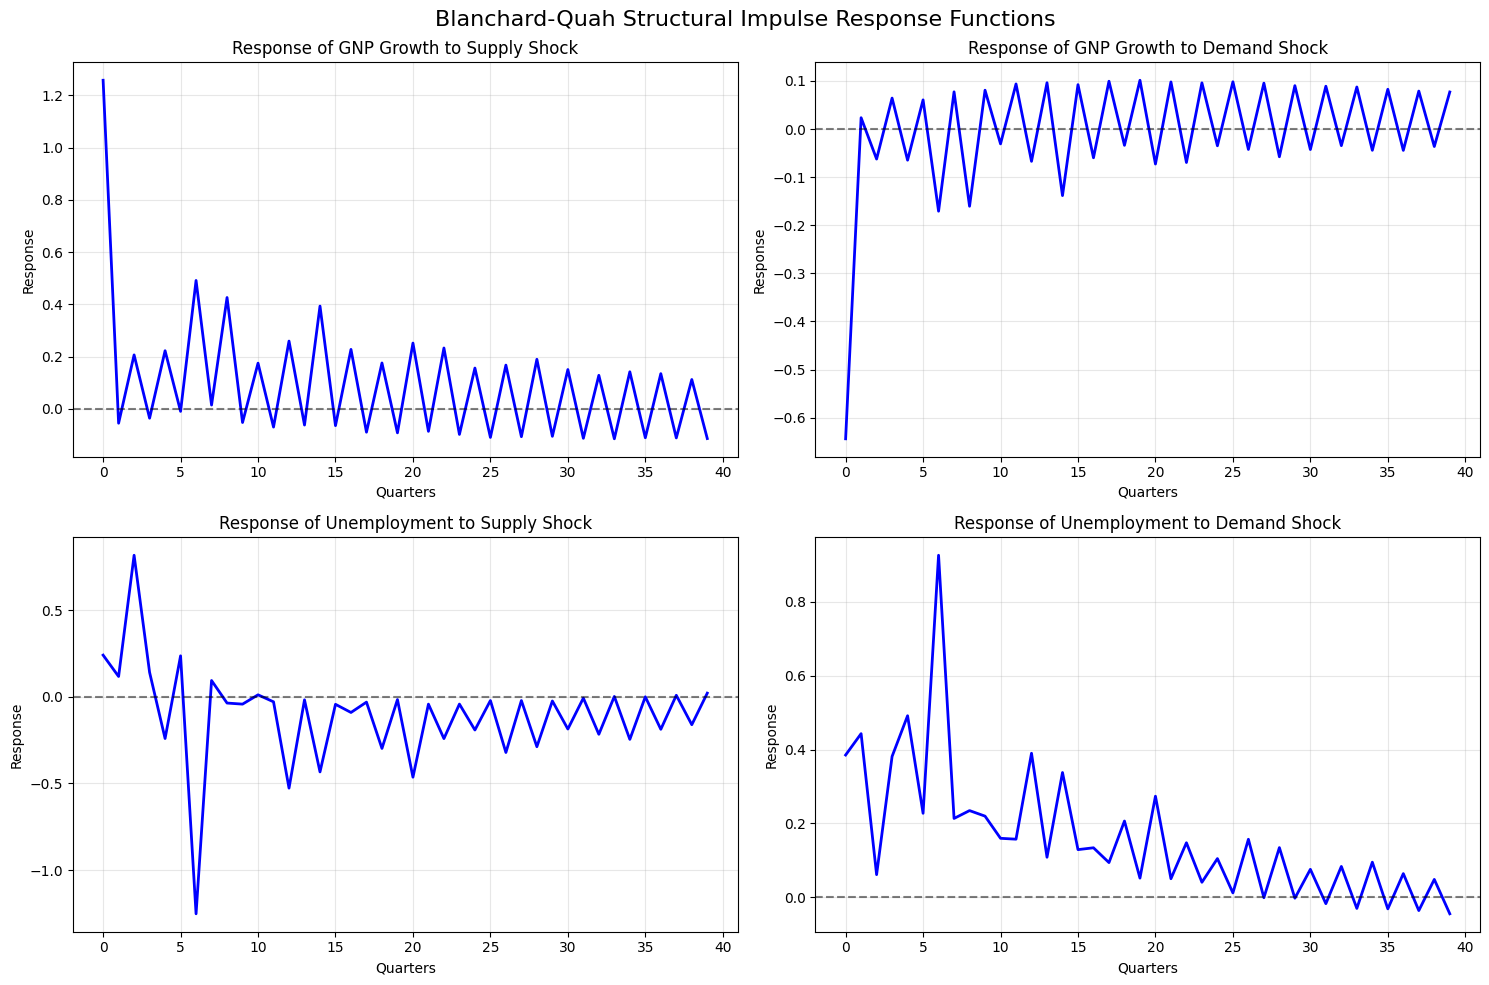


--- Forecast Error Variance Decomposition ---
Percentage of variance explained by each shock:

Horizon: 4 quarters
GNP Growth:
  Supply Shock: 79.4%
  Demand Shock: 20.6%
Unemployment:
  Supply Shock: 60.6%
  Demand Shock: 39.4%

Horizon: 8 quarters
GNP Growth:
  Supply Shock: 80.5%
  Demand Shock: 19.5%
Unemployment:
  Supply Shock: 59.2%
  Demand Shock: 40.8%

Horizon: 12 quarters
GNP Growth:
  Supply Shock: 80.8%
  Demand Shock: 19.2%
Unemployment:
  Supply Shock: 57.1%
  Demand Shock: 42.9%

Horizon: 20 quarters
GNP Growth:
  Supply Shock: 81.1%
  Demand Shock: 18.9%
Unemployment:
  Supply Shock: 57.7%
  Demand Shock: 42.3%

Horizon: 40 quarters
GNP Growth:
  Supply Shock: 80.9%
  Demand Shock: 19.1%
Unemployment:
  Supply Shock: 60.9%
  Demand Shock: 39.1%

--- Analysis Complete ---
Supply shocks should have permanent effects on GNP growth.
Demand shocks should have only temporary effects on GNP growth.
Both shocks can affect unemployment in the short and long run.


In [28]:
# --- 4. Calculate Structural Impulse Response Functions ---
def compute_structural_irf(A_matrices, S, periods=40):
    """
    Compute structural impulse response functions.
    """
    n = S.shape[0]
    k = len(A_matrices)
    
    # Initialize IRF array: [variables, shocks, time periods]
    irf = np.zeros((n, n, periods))
    
    # Period 0: immediate response
    irf[:, :, 0] = S
    
    # Compute companion form for easier calculation
    # The companion matrix F allows us to compute the impulse responses iteratively
    # for higher lags.
    if k > 1:
        F = np.zeros((n*k, n*k))
        # Top block contains the A_matrices stacked horizontally
        F[:n, :] = np.hstack(A_matrices)
        # Bottom block creates the identity matrix for the lagged variables
        F[n:, :-n] = np.eye(n*(k-1))
        
        # Initial condition for companion form
        Psi_0 = np.zeros((n*k, n))
        Psi_0[:n, :] = S
    else: # For k=1, the companion matrix is just A1
        F = A_matrices[0]
        Psi_0 = S # In this case, Psi_0 is just S
    
    # Compute IRFs using the companion form
    for t in range(1, periods):
        if k > 1:
            # Psi_t = F^t * Psi_0
            Psi_t = np.linalg.matrix_power(F, t) @ Psi_0
            irf[:, :, t] = Psi_t[:n, :] # Extract the relevant n x n block
        else:
            irf[:, :, t] = np.linalg.matrix_power(F, t) @ S
    
    return irf

# Compute IRFs
irf = compute_structural_irf(A_matrices, S, periods=40)

print(f"\nStructural IRFs computed for {irf.shape[2]} periods")

# --- 5. Plot the Results ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Blanchard-Quah Structural Impulse Response Functions', fontsize=16)

periods = np.arange(40)
var_names = ['GNP Growth', 'Unemployment']
shock_names = ['Supply Shock', 'Demand Shock']

for i in range(2):  # Iterate over variables (rows in the plot grid)
    for j in range(2):  # Iterate over shocks (columns in the plot grid)
        ax = axes[i, j]
        response = irf[i, j, :] # Response of variable 'i' to shock 'j'
        
        ax.plot(periods, response, 'b-', linewidth=2)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax.set_title(f'Response of {var_names[i]} to {shock_names[j]}')
        ax.set_xlabel('Quarters')
        ax.set_ylabel('Response')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 6. Variance Decomposition ---
def variance_decomposition(irf, periods_list=[4, 8, 12, 20, 40]):
    """
    Calculate forecast error variance decomposition.
    """
    n_vars, n_shocks, n_periods = irf.shape
    
    print("\n--- Forecast Error Variance Decomposition ---")
    print("Percentage of variance explained by each shock:")
    
    for period in periods_list:
        if period <= n_periods:
            print(f"\nHorizon: {period} quarters")
            
            # Calculate cumulative variance
            total_var = np.zeros(n_vars)
            shock_var = np.zeros((n_vars, n_shocks))
            
            for t in range(period):
                for i in range(n_vars):
                    for j in range(n_shocks):
                        # The contribution of shock j to the variance of variable i at horizon t
                        shock_var[i, j] += irf[i, j, t]**2
                        # Total variance for variable i at horizon t
                        total_var[i] += irf[i, j, t]**2
            
            # Calculate percentages
            for i in range(n_vars):
                print(f"{var_names[i]}:")
                for j in range(n_shocks):
                    pct = (shock_var[i, j] / total_var[i]) * 100 if total_var[i] > 0 else 0
                    print(f"  {shock_names[j]}: {pct:.1f}%")

# Calculate variance decomposition
variance_decomposition(irf)

print("\n--- Analysis Complete ---")
print("Supply shocks should have permanent effects on GNP growth.")
print("Demand shocks should have only temporary effects on GNP growth.")
print("Both shocks can affect unemployment in the short and long run.")



--- Blanchard-Quah Decomposition Results ---
Structural impact matrix S (Blanchard-Quah):
[[ 1.25741191 -0.64389807]
 [ 0.24034708  0.38507947]]

Long-run multiplier matrix C(1) (Blanchard-Quah):
[[ 2.25232021  3.76614377]
 [-5.1801626   7.03453562]]

Blanchard-Quah Structural IRFs computed for 40 periods

--- Cholesky Decomposition Results ---
Structural impact matrix S (Cholesky):
[[1.41268872 0.        ]
 [0.0384114  0.45230242]]

Cholesky IRFs computed for 40 periods


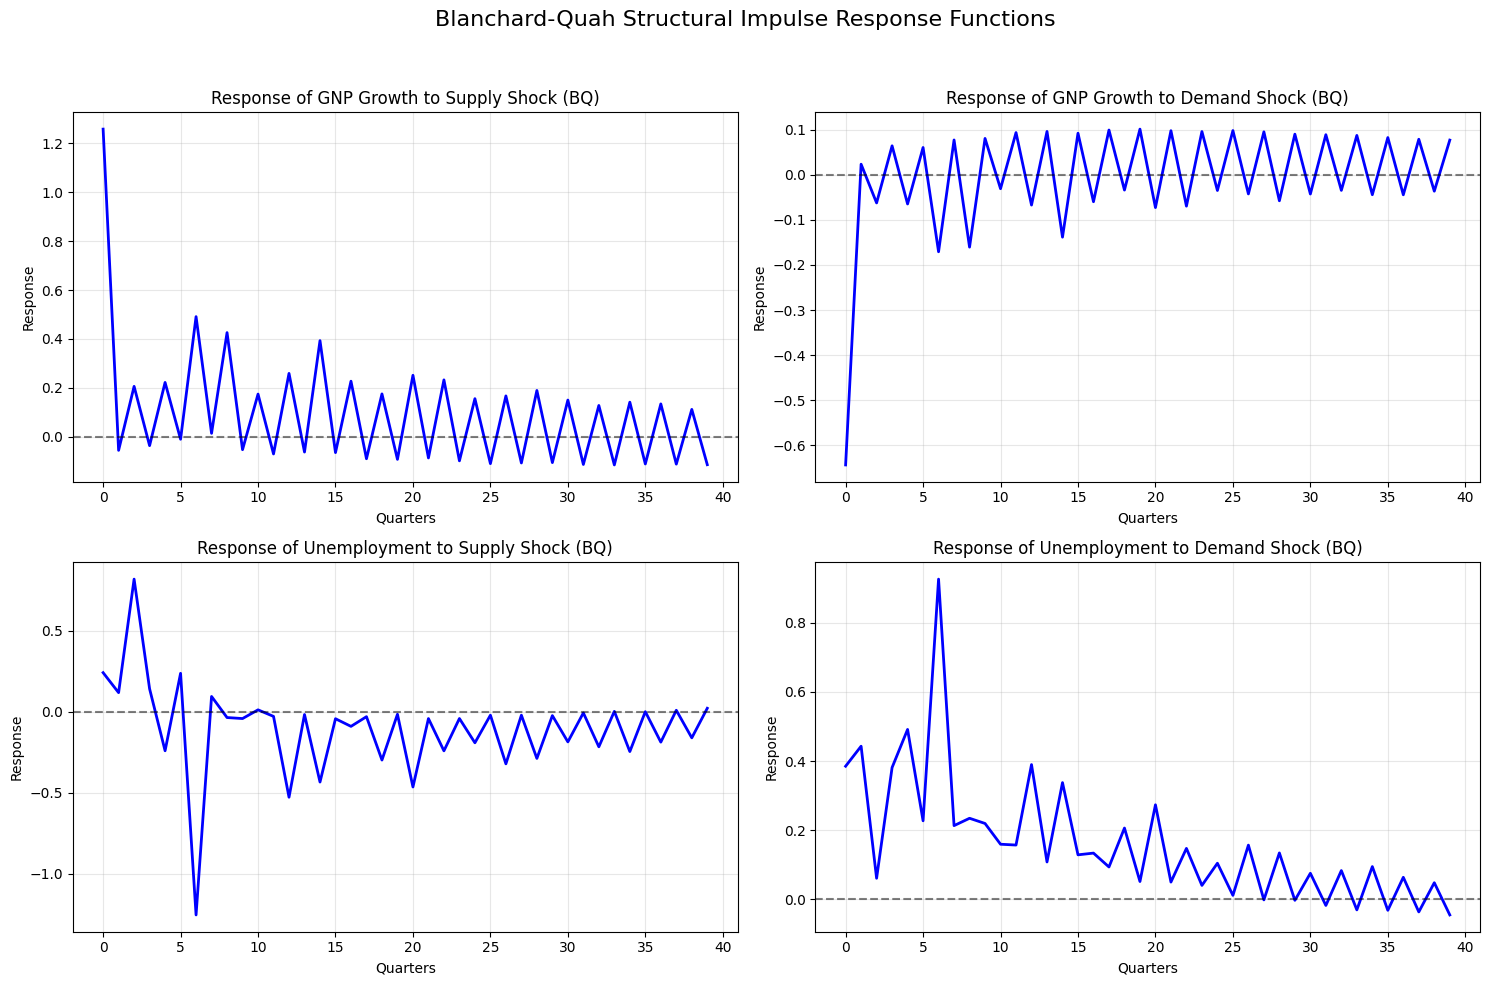

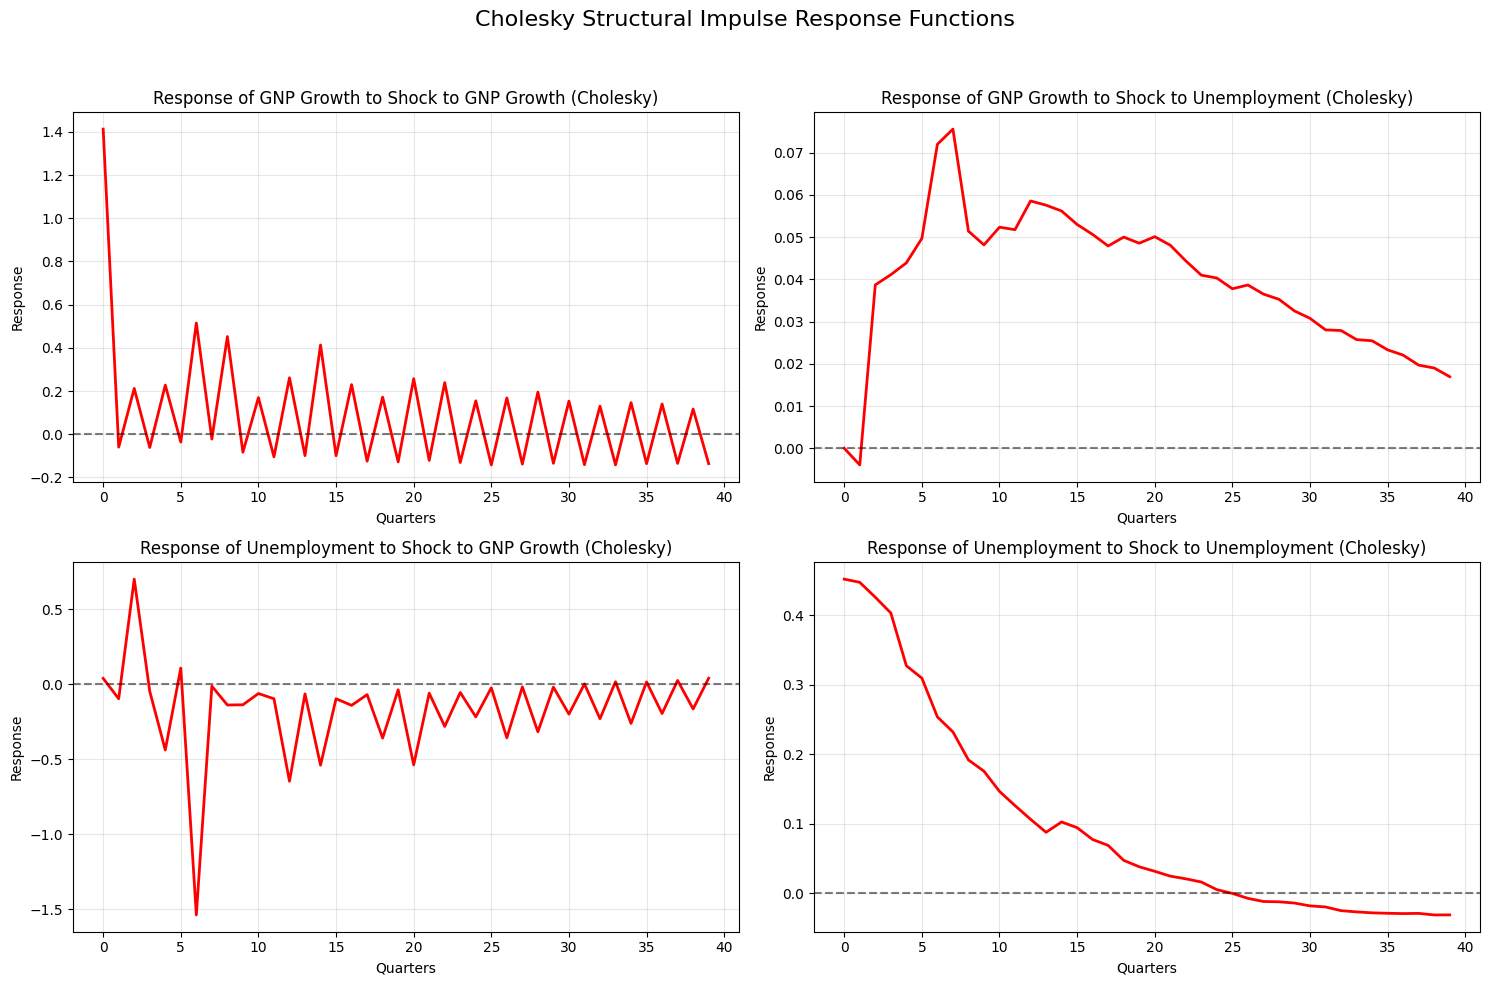


--- Forecast Error Variance Decomposition: Blanchard-Quah ---
Percentage of variance explained by each shock:

Horizon: 4 quarters
GNP Growth:
  Supply Shock (BQ): 79.4%
  Demand Shock (BQ): 20.6%
Unemployment:
  Supply Shock (BQ): 60.6%
  Demand Shock (BQ): 39.4%

Horizon: 8 quarters
GNP Growth:
  Supply Shock (BQ): 80.5%
  Demand Shock (BQ): 19.5%
Unemployment:
  Supply Shock (BQ): 59.2%
  Demand Shock (BQ): 40.8%

Horizon: 12 quarters
GNP Growth:
  Supply Shock (BQ): 80.8%
  Demand Shock (BQ): 19.2%
Unemployment:
  Supply Shock (BQ): 57.1%
  Demand Shock (BQ): 42.9%

Horizon: 20 quarters
GNP Growth:
  Supply Shock (BQ): 81.1%
  Demand Shock (BQ): 18.9%
Unemployment:
  Supply Shock (BQ): 57.7%
  Demand Shock (BQ): 42.3%

Horizon: 40 quarters
GNP Growth:
  Supply Shock (BQ): 80.9%
  Demand Shock (BQ): 19.1%
Unemployment:
  Supply Shock (BQ): 60.9%
  Demand Shock (BQ): 39.1%

--- Forecast Error Variance Decomposition: Cholesky ---
Percentage of variance explained by each shock:

Horiz

In [29]:
#Comparison with Cholesky Decomposition and Blanchard-Quah Decomposition

# --- 1. Implement Blanchard-Quah Decomposition Manually ---
def blanchard_quah_decomposition(var_results, periods=40):
    """
    Implement the Blanchard-Quah decomposition with long-run restrictions.
    
    The key insight is that we need to recover the structural shocks by imposing
    the long-run neutrality restriction: demand shocks have no long-run effect on output.
    """
    
    # Get VAR coefficient matrices from results.params (a (1 + k*n) x n array)
    coefs_matrix = var_results.params.values
    k = var_results.k_ar  # number of lags
    n = var_results.neqs  # number of variables
    
    A_matrices = []
    # Loop for each lag (from 1 to k)
    for i in range(k):
        # The coefficients for lag (i+1) start at row index 1 + i*n (skipping the constant row)
        # and span 'n' rows.
        start_row = 1 + i * n
        end_row = start_row + n
        
        # Extract the n x n matrix for the current lag
        # A_i represents the coefficients for the i-th lag, where A_i[row, col]
        # is the coefficient of variable 'row' at lag 'i' in the equation for variable 'col'.
        # statsmodels stores params such that rows are variables at lags, columns are equations.
        # So, we directly slice the 2D array.
        A_i = coefs_matrix[start_row:end_row, :]
        A_matrices.append(A_i)
    
    # Calculate long-run multiplier matrix C(1) = [I - A1 - A2 - ... - Ak]^(-1)
    I = np.eye(n)
    A_sum = np.sum(A_matrices, axis=0)
    C_1 = inv(I - A_sum)
    
    # Get reduced-form residual covariance matrix
    Sigma_u = np.cov(var_results.resid.T)
    
    # Apply Blanchard-Quah restrictions using Cholesky decomposition
    # We need C(1) * S * S' * C(1)' = Sigma_u where S is lower triangular
    # This ensures that the second shock has no long-run effect on the first variable
    
    # Compute the matrix for decomposition
    temp_matrix = C_1 @ Sigma_u @ C_1.T
    
    # Cholesky decomposition to get structural impact matrix
    try:
        L = cholesky(temp_matrix, lower=True)
        S = inv(C_1) @ L
    except np.linalg.LinAlgError:
        # If Cholesky fails, use alternative approach (e.g., for non-positive definite matrices)
        # This can happen if the data is highly collinear or has zero variance.
        eigenvals, eigenvecs = np.linalg.eigh(temp_matrix)
        # Ensure eigenvalues are non-negative for sqrt, add a small epsilon
        L = eigenvecs @ np.diag(np.sqrt(np.maximum(eigenvals, 1e-12))) @ eigenvecs.T
        S = inv(C_1) @ L
    
    return S, C_1, A_matrices, Sigma_u

# Apply the decomposition
S_bq, C_1_bq, A_matrices_bq, Sigma_u_bq = blanchard_quah_decomposition(results)

print("\n--- Blanchard-Quah Decomposition Results ---")
print("Structural impact matrix S (Blanchard-Quah):")
print(S_bq)
print("\nLong-run multiplier matrix C(1) (Blanchard-Quah):")
print(C_1_bq)

# --- 4. Calculate Structural Impulse Response Functions (Common Function) ---
def compute_irf(A_matrices, S_impact, periods=40):
    """
    Compute impulse response functions given VAR coefficients and an impact matrix S.
    """
    n = S_impact.shape[0]
    k = len(A_matrices)
    
    # Initialize IRF array: [variables, shocks, time periods]
    irf = np.zeros((n, n, periods))
    
    # Period 0: immediate response
    irf[:, :, 0] = S_impact
    
    # Compute companion form for easier calculation
    if k > 1:
        F = np.zeros((n*k, n*k))
        F[:n, :] = np.hstack(A_matrices)
        F[n:, :-n] = np.eye(n*(k-1))
        
        Psi_0 = np.zeros((n*k, n))
        Psi_0[:n, :] = S_impact
    else:
        F = A_matrices[0]
        Psi_0 = S_impact
    
    # Compute IRFs
    for t in range(1, periods):
        if k > 1:
            Psi_t = np.linalg.matrix_power(F, t) @ Psi_0
            irf[:, :, t] = Psi_t[:n, :]
        else:
            irf[:, :, t] = np.linalg.matrix_power(F, t) @ S_impact
    
    return irf

# Compute IRFs for Blanchard-Quah
irf_bq = compute_irf(A_matrices_bq, S_bq, periods=40)

print(f"\nBlanchard-Quah Structural IRFs computed for {irf_bq.shape[2]} periods")

# --- 2. Implement Cholesky Decomposition ---
# Cholesky decomposition imposes a recursive identification scheme.
# The order of variables matters: here, gnp_growth is ordered first,
# meaning it is assumed to be unaffected contemporaneously by unemployment shocks,
# but unemployment can be affected by gnp_growth shocks.
L_cholesky = cholesky(sigma_u, lower=True)

print("\n--- Cholesky Decomposition Results ---")
print("Structural impact matrix S (Cholesky):")
print(L_cholesky)

# Compute IRFs for Cholesky
irf_cholesky = compute_irf(A_matrices_bq, L_cholesky, periods=40) # Reuse A_matrices from VAR

print(f"\nCholesky IRFs computed for {irf_cholesky.shape[2]} periods")

# --- 3. Plot the Results (Blanchard-Quah vs. Cholesky) ---
periods_range = np.arange(40)
var_names = ['GNP Growth', 'Unemployment']
bq_shock_names = ['Supply Shock (BQ)', 'Demand Shock (BQ)']
cholesky_shock_names = ['Shock to GNP Growth (Cholesky)', 'Shock to Unemployment (Cholesky)']

# Plot for Blanchard-Quah
fig_bq, axes_bq = plt.subplots(2, 2, figsize=(15, 10))
fig_bq.suptitle('Blanchard-Quah Structural Impulse Response Functions', fontsize=16)

for i in range(2):  # variables
    for j in range(2):  # shocks
        ax = axes_bq[i, j]
        response = irf_bq[i, j, :]
        ax.plot(periods_range, response, 'b-', linewidth=2)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax.set_title(f'Response of {var_names[i]} to {bq_shock_names[j]}')
        ax.set_xlabel('Quarters')
        ax.set_ylabel('Response')
        ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot for Cholesky
fig_cholesky, axes_cholesky = plt.subplots(2, 2, figsize=(15, 10))
fig_cholesky.suptitle('Cholesky Structural Impulse Response Functions', fontsize=16)

for i in range(2):  # variables
    for j in range(2):  # shocks
        ax = axes_cholesky[i, j]
        response = irf_cholesky[i, j, :]
        ax.plot(periods_range, response, 'r-', linewidth=2) # Use a different color for Cholesky
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax.set_title(f'Response of {var_names[i]} to {cholesky_shock_names[j]}')
        ax.set_xlabel('Quarters')
        ax.set_ylabel('Response')
        ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# --- 7. Variance Decomposition (Common Function) ---
def variance_decomposition(irf, var_names, shock_names, periods_list=[4, 8, 12, 20, 40], title=""):
    """
    Calculate forecast error variance decomposition.
    """
    n_vars, n_shocks, n_periods = irf.shape
    
    print(f"\n--- Forecast Error Variance Decomposition: {title} ---")
    print("Percentage of variance explained by each shock:")
    
    for period in periods_list:
        if period <= n_periods:
            print(f"\nHorizon: {period} quarters")
            
            total_var = np.zeros(n_vars)
            shock_var = np.zeros((n_vars, n_shocks))
            
            for t in range(period):
                for i in range(n_vars):
                    for j in range(n_shocks):
                        shock_var[i, j] += irf[i, j, t]**2
                        total_var[i] += irf[i, j, t]**2
            
            for i in range(n_vars):
                print(f"{var_names[i]}:")
                for j in range(n_shocks):
                    pct = (shock_var[i, j] / total_var[i]) * 100 if total_var[i] > 0 else 0
                    print(f"  {shock_names[j]}: {pct:.1f}%")

# Calculate variance decomposition for Blanchard-Quah
variance_decomposition(irf_bq, var_names, bq_shock_names, title="Blanchard-Quah")

# Calculate variance decomposition for Cholesky
variance_decomposition(irf_cholesky, var_names, cholesky_shock_names, title="Cholesky")

print("\n--- Analysis Complete ---")
print("\nComparison Notes:")
print("Blanchard-Quah (BQ) decomposition imposes long-run restrictions (demand shocks have no permanent effect on output).")
print("Cholesky decomposition imposes short-run recursive restrictions (ordering matters: GNP growth affects unemployment contemporaneously, but not vice-versa).")
print("\nObserve how the IRFs and variance decompositions differ based on these distinct identification assumptions.")
print("For GNP Growth, BQ's 'Supply Shock' should show a permanent effect, while Cholesky's 'Shock to GNP Growth' might not strictly adhere to this long-run neutrality if the ordering doesn't imply it.")
print("The interpretation of shocks differs: BQ aims to identify 'supply' and 'demand' shocks based on long-run properties, while Cholesky identifies shocks based on their contemporaneous causal ordering.")
